In [135]:
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import seaborn as sns
import pandas as pd
import torch
import gymnasium as gym
import gym_bart
import itertools
from umap import UMAP
from plotting_utils import (
    set_rc, 
    add_abc_to_subaxes, 
    colors, 
    rgb_colors,
    bart_plot_colors,
)
from model_evaluation import (
    forced_action_evaluate, 
    bart_color_n_callback,
    meta_bart_multi_callback,
    reshape_parallel_evalu_res,
    forced_action_evaluate_multi,
    reshape_activations,
)
from bart_behavior_analysis import (
    plot_1color5fsize,
    plot_1colornfsize
)
from read_experiments import average_runs, load_exp_df
import re

from functools import partial
import sys
sys.path.append('../')
from ppo.envs import make_vec_env
import pickle
from tqdm import tqdm
from collections import defaultdict

from sklearn.decomposition import PCA

set_rc()

ImportError: cannot import name 'bart_plot_colors' from 'plotting_utils' (c:\Users\14and\Desktop\Work\github\bart_ppo\write_and_test\plotting_utils.py)

In [70]:
from scipy.stats import skew, kurtosis
from scipy.optimize import curve_fit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

def test_rnn_step_mods(res, model, ep, steps):
    '''Test how modifications to rnn steps affect a model's output'''
    pos_scores = np.zeros((len(steps), 64))
    neg_scores = np.zeros((len(steps), 64))

    for j, step in enumerate(steps):
        rnn_hx = res['rnn_hxs'][ep][step]
        obs = res['obs'][ep][step]
        masks = res['masks'][ep][step]

        obs = torch.tensor(np.full((64, obs.shape[0]), obs))
        masks = torch.tensor(masks)
        rnn_hx_mod = torch.tensor(np.full((64, 64), rnn_hx))

        for i in range(64):
            rnn_hx_mod[i, i] -= 2
        outputs = model.act(obs, rnn_hx_mod, masks)
        p = outputs['probs'][:, 1]
        neg_scores[j] = p.detach()

        for i in range(64):
            rnn_hx_mod[i, i] += 4
        outputs = model.act(obs, rnn_hx_mod, masks)
        p = outputs['probs'][:, 1]
        pos_scores[j] = p.detach()

    for j, step in enumerate(steps):
        p = res['action_probs'][ep][step][1]
        neg_scores[j] -= p
        pos_scores[j] -= p
    
    return pos_scores, neg_scores

def find_decision_nodes(res, model, ep=0, full_ret=False):
    presses = np.argwhere((res['actions'][ep] == 1).reshape(-1)).reshape(-1)
    ends = np.array(res['data']['balloon_step'][ep])
    end_presses = np.intersect1d(presses, ends)
    penult_steps = end_presses - 1
    
    pos_scores, neg_scores = test_rnn_step_mods(res, model, ep, penult_steps)
    pos_scores = np.mean(pos_scores, axis=0)
    neg_scores = np.mean(neg_scores, axis=0)
    decision_nodes = (pos_scores > 0.2) | (neg_scores > 0.2)

    if full_ret:
        return decision_nodes, pos_scores, neg_scores, penult_steps
    return decision_nodes

def find_decision_nodes_efficient(res, model, ep=0):
    presses = np.argwhere((res['actions'][ep] == 1).reshape(-1)).reshape(-1)
    ends = np.array(res['data']['balloon_step'][ep])
    end_presses = np.intersect1d(presses, ends)
    penult_steps = end_presses - 1
    
    o = res['obs'][ep][0]
    rnn_hx_mod = torch.tensor(np.zeros((64*len(penult_steps), 64)), dtype=torch.float)
    obs = torch.tensor(np.zeros((64*len(penult_steps), o.shape[0])), dtype=torch.float)
    masks = torch.tensor(res['masks'][ep][0])
    probs = np.zeros(len(penult_steps))
    for i, step in enumerate(penult_steps):
        rnn_hx = res['rnn_hxs'][ep][step]
        o = res['obs'][ep][step]
        probs[i] = res['action_probs'][ep][step][1]
        
        rnn_hx_mod[i*64:(i+1)*64] = torch.tensor(rnn_hx)
        obs[i*64:(i+1)*64] = torch.tensor(o)
        delt_rnn = res['rnn_hxs'][ep][step+1] - res['rnn_hxs'][ep][step]
        delt_rnn = torch.tensor(np.sign(delt_rnn)*2)
        for j in range(64):
            rnn_hx_mod[i*64+j, j] += delt_rnn[j]
        
    output = model.act(obs, rnn_hx_mod, masks)
    p = output['probs'][:, 1].detach()
    p = np.array(p).reshape(64, -1)
    scores = p - probs
    scores = np.mean(scores, axis=1)
    decision_nodes = scores > 0.2
    return decision_nodes
    
    

def measure_rnn_influence(res, model, ep, step, decision_nodes=None, ap=False,
                          large_kick=False):
    '''Measure how much influence individual nodes or group of nodes have on a certain step
    
    decision_nodes: pass boolean array of size 64 to differentiate decision and non-decision nodes
    ap: if True, compute the influence on action probabilities
    '''
    delt_rnn = res['rnn_hxs'][ep][step+1] - res['rnn_hxs'][ep][step]
    if large_kick:
        delt_rnn = np.sign(delt_rnn) * 2
    rnn_hx = res['rnn_hxs'][ep][step]

    if decision_nodes is not None:
        size = 2
    else:
        size = 64
    
    rnn_hx_mod = torch.tensor(np.full((size, 64), rnn_hx))
    if decision_nodes is not None:
        rnn_hx_mod[0, decision_nodes] += delt_rnn[decision_nodes]
        rnn_hx_mod[1, ~decision_nodes] += delt_rnn[~decision_nodes]

    else:
        for i in range(64):
            rnn_hx_mod[i, i] += delt_rnn[i]
    shared0 = res['activations']['shared0'][ep][step]
    actor0 = res['activations']['actor0'][ep][step]
    obs = res['obs'][ep][step]
    masks = res['masks'][ep][step]

    shared0 = torch.tensor(np.full((size, 64,), shared0))
    actor0 = torch.tensor(np.full((size, 64,), actor0))

    # next_rnn_hx = model.base._forward_gru(shared0, rnn_hx_mod, masks)[0]
    next_rnn_hx = model.base._forward_gru(obs, rnn_hx_mod, masks)[0]
    actor0mod = model.base.actor0(next_rnn_hx)

    delt_actor0 = (actor0mod - actor0).detach()
    
    if ap:
        actor1 = model.base.actor1(actor0mod)
        logits = model.dist(actor1)
        probs = logits.probs
        return delt_actor0, probs

    return delt_actor0
    
    
def comb_pca(res, layer='shared1'):
    activ = res['activations'][layer]
    ep_lens = [len(a) for a in activ]
    all_activ = torch.vstack(activ)
    pca = PCA(n_components=10)
    all_pca_a = pca.fit_transform(all_activ)
    pca_as = []

    cur_step = 0
    for ep_len in ep_lens:
        pca_as.append(all_pca_a[cur_step:cur_step+ep_len])
        cur_step += ep_len
        
    return pca_as


def starts_and_ends(res):
    starts = []
    ends = []
    for ep in range(len(res['data']['balloon_step'])):
        end = np.array(res['data']['balloon_step'][ep])
        start = [0]
        for step in end[:-1]:
            start.append(np.argmax(res['actions'][ep].reshape(-1)[step+1:] == 1) + step+1)
        ends.append(end)
        starts.append(start)
    return np.array(starts), np.array(ends)


def unnormalize_obs(obs, obs_rms):
    return (obs * np.sqrt(obs_rms.var + 1e-8)) + obs_rms.mean

def get_sizes(res, obs_rms):
    sizes = []
    for ep in range(17):
        obs = unnormalize_obs(res['obs'][ep], obs_rms)
        sizes.append(obs[:, 5].round(2))
    return sizes

def linear_best_fit(x, y):
    
    m, b = np.polyfit(x, y, 1)
    ypred = m*x + b
    
    ss_res = np.sum((y - ypred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res / ss_tot

    return (m, b), r2

def p_best_fit(x, y, p):
    x_transformed = np.power(x, p)
    x_design = np.vstack([x_transformed, np.ones(len(x_transformed))]).T
    coefficients, residuals, _, _ = np.linalg.lstsq(x_design, y, rcond=None)
    m, b = coefficients
    ypred = m * x_transformed + b
    
    ss_res = np.sum((y - ypred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res / ss_tot

    return (m, b), r2

def sigmoid(x, x0, k):
    return 1 / (1 + np.exp(-k * (x - x0)))

def fit_ramp(res, pca=0, layer='actor0', idxs=None, plot=False):
    '''
    Find a best fit sigmoidal function to see whether there is clear ramping signal
    '''
    pca_as = comb_pca(res, layer)
    pca_a = np.vstack(pca_as)[:, pca]
    ap = np.vstack(res['action_probs'])[:, 1]

    if idxs is not None:
        pca_a = pca_a[idxs]
        ap = ap[idxs]
    popt, pcov = curve_fit(sigmoid, pca_a, ap, p0=[1, 1])

    x0, k = popt
    ypred = sigmoid(pca_a, x0, k)

    err_resid = (ypred - ap)**2
    err_tot = (np.mean(ap) - ap)**2
    r2_indiv = 1 - err_resid / err_tot
    r2 = 1 - err_resid.sum() / err_tot.sum()
    
    x = np.linspace(pca_a.min(), pca_a.max(), 100)
    
    if plot:
        fig, ax = pplt.subplots()
        ax.scatter(pca_a, ap, alpha=.05)
        ax.plot(x, sigmoid(x, x0, k))
        # ax.scatter(pca_a[resid > 0.03], ap[resid > 0.03])
        ax.scatter(pca_a[r2_indiv > 0.9], ap[r2_indiv > 0.9], alpha=.05)
        ax.format(xlabel=f'PCA {pca+1}', ylabel='Button press prob')

    return x, x0, k, ypred, r2_indiv, r2

def find_best_pca_ramp(res, layer='actor0'):
    '''
    Find which pca in the layer best looks like a ramping signal
    return: pca_number, r2_score
    '''
    ap = np.vstack(res['action_probs'])[:, 1]
    r2s = []
    for i in range(10):
        r2 = []
        try:
            x, x0, k, ypred, r2_indiv, r2_1 = fit_ramp(res, pca=i, plot=False, layer=layer)
            r2.append(r2_1)
            if (ap > ypred).sum() > (ap < ypred).sum():
                idxs = ap > ypred
            else:
                idxs = ap < ypred
            x, x0, k, ypred, r2_indiv, r2_2 = fit_ramp(res, pca=i, plot=False, layer=layer, idxs=idxs)
            r2.append(r2_2)
            # r2s.append(np.clip(r2_indiv, 0, 1).mean())
        except:
            r2.append(0)
        r2s.append(np.max(r2))
    
    pca = np.argmax(r2s)
    return pca, r2s[pca]

def score_logistic_classifiers(res):
    '''
    Score how well decision can be classified by logistic regression
    in each of the layers, with PCAs and with all activations
    '''
    layers = ['shared0', 'shared1', 'actor0', 'actor1', 'critic0', 'critic1']
    f1_scores = np.zeros((6, 11))
    individual_scores = np.zeros((6, 64))
    
    actions  = np.vstack(res['actions']).reshape(-1)
    for n, layer in enumerate(layers):
        pca_as = comb_pca(res, layer)
        pcas = np.vstack(pca_as)
        activ = np.vstack(res['activations'][layer])

        lm = LogisticRegression()
        lm.fit(activ, actions)
        ypred = lm.predict(activ)
        f1_scores[n, 0] = f1_score(actions, ypred)
        
        for j in range(10):
            lm = LogisticRegression()
            lm.fit(pcas[:, j].reshape(-1, 1), actions)
            ypred = lm.predict(pcas[:, j].reshape(-1, 1))
            f1_scores[n, j+1] = f1_score(actions, ypred)
        
        individual_scores[n] = np.abs(activ).mean(axis=0)*np.abs(lm.coef_).reshape(-1)
    
    return f1_scores, individual_scores
        

def test_pca_bimodality(res):
    layers = ['shared1', 'actor0']
    coefs = []
    for i, layer in enumerate(layers):
        pca_as = comb_pca(res, layer)
        c = []
        # Only took at top 3 PCAs
        for j in range(3):
            pca_a = np.vstack(pca_as)[:, j]
            s = skew(pca_a)
            k = kurtosis(pca_a)
            n = len(pca_a)
            bi_coef = ((s ** 2) + 1) / (k + 3 * ((n - 1) ** 2) / ((n - 2) * (n - 3)))
            c.append(bi_coef)

        coefs.append(c)
    return coefs
    


In [ ]:
def test_rnn_step_mods(res, model, ep, steps):
    '''Test how modifications to rnn steps affect a model's output'''
    pos_scores = np.zeros((len(steps), 64))
    neg_scores = np.zeros((len(steps), 64))

    for j, step in enumerate(steps):
        rnn_hx = res['rnn_hxs'][ep][step]
        obs = res['obs'][ep][step]
        masks = res['masks'][ep][step]

        obs = torch.tensor(np.full((64, obs.shape[0]), obs))
        masks = torch.tensor(masks)
        rnn_hx_mod = torch.tensor(np.full((64, 64), rnn_hx))

        for i in range(64):
            rnn_hx_mod[i, i] -= 2
        outputs = model.act(obs, rnn_hx_mod, masks)
        p = outputs['probs'][:, 1]
        neg_scores[j] = p.detach()

        for i in range(64):
            rnn_hx_mod[i, i] += 4
        outputs = model.act(obs, rnn_hx_mod, masks)
        p = outputs['probs'][:, 1]
        pos_scores[j] = p.detach()

    for j, step in enumerate(steps):
        p = res['action_probs'][ep][step][1]
        neg_scores[j] -= p
        pos_scores[j] -= p
    
    return pos_scores, neg_scores

def find_decision_nodes(res, model, ep=0, full_ret=False):
    presses = np.argwhere((res['actions'][ep] == 1).reshape(-1)).reshape(-1)
    ends = np.array(res['data']['balloon_step'][ep])
    end_presses = np.intersect1d(presses, ends)
    penult_steps = end_presses - 1
    
    pos_scores, neg_scores = test_rnn_step_mods(res, model, ep, penult_steps)
    pos_scores = np.mean(pos_scores, axis=0)
    neg_scores = np.mean(neg_scores, axis=0)
    decision_nodes = (pos_scores > 0.2) | (neg_scores > 0.2)

    if full_ret:
        return decision_nodes, pos_scores, neg_scores, penult_steps
    return decision_nodes

def find_decision_nodes_efficient(res, model, ep=0):
    presses = np.argwhere((res['actions'][ep] == 1).reshape(-1)).reshape(-1)
    ends = np.array(res['data']['balloon_step'][ep])
    end_presses = np.intersect1d(presses, ends)
    penult_steps = end_presses - 1
    
    o = res['obs'][ep][0]
    rnn_hx_mod = torch.tensor(np.zeros((64*len(penult_steps), 64)), dtype=torch.float)
    obs = torch.tensor(np.zeros((64*len(penult_steps), o.shape[0])), dtype=torch.float)
    masks = torch.tensor(res['masks'][ep][0])
    probs = np.zeros(len(penult_steps))
    for i, step in enumerate(penult_steps):
        rnn_hx = res['rnn_hxs'][ep][step]
        o = res['obs'][ep][step]
        probs[i] = res['action_probs'][ep][step][1]
        
        rnn_hx_mod[i*64:(i+1)*64] = torch.tensor(rnn_hx)
        obs[i*64:(i+1)*64] = torch.tensor(o)
        delt_rnn = res['rnn_hxs'][ep][step+1] - res['rnn_hxs'][ep][step]
        delt_rnn = torch.tensor(np.sign(delt_rnn)*2)
        for j in range(64):
            rnn_hx_mod[i*64+j, j] += delt_rnn[j]
        
    output = model.act(obs, rnn_hx_mod, masks)
    p = output['probs'][:, 1].detach()
    p = np.array(p).reshape(64, -1)
    scores = p - probs
    scores = np.mean(scores, axis=1)
    decision_nodes = scores > 0.2
    return decision_nodes
    
    

def measure_rnn_influence(res, model, ep, step, decision_nodes=None, ap=False,
                          large_kick=False):
    '''Measure how much influence individual nodes or group of nodes have on a certain step
    
    decision_nodes: pass boolean array of size 64 to differentiate decision and non-decision nodes
    ap: if True, compute the influence on action probabilities
    '''
    delt_rnn = res['rnn_hxs'][ep][step+1] - res['rnn_hxs'][ep][step]
    if large_kick:
        delt_rnn = np.sign(delt_rnn) * 2
    rnn_hx = res['rnn_hxs'][ep][step]

    if decision_nodes is not None:
        size = 2
    else:
        size = 64
    
    rnn_hx_mod = torch.tensor(np.full((size, 64), rnn_hx))
    if decision_nodes is not None:
        rnn_hx_mod[0, decision_nodes] += delt_rnn[decision_nodes]
        rnn_hx_mod[1, ~decision_nodes] += delt_rnn[~decision_nodes]

    else:
        for i in range(64):
            rnn_hx_mod[i, i] += delt_rnn[i]
    shared0 = res['activations']['shared0'][ep][step]
    actor0 = res['activations']['actor0'][ep][step]
    obs = res['obs'][ep][step]
    masks = res['masks'][ep][step]

    shared0 = torch.tensor(np.full((size, 64,), shared0))
    actor0 = torch.tensor(np.full((size, 64,), actor0))

    # next_rnn_hx = model.base._forward_gru(shared0, rnn_hx_mod, masks)[0]
    next_rnn_hx = model.base._forward_gru(obs, rnn_hx_mod, masks)[0]
    actor0mod = model.base.actor0(next_rnn_hx)

    delt_actor0 = (actor0mod - actor0).detach()
    
    if ap:
        actor1 = model.base.actor1(actor0mod)
        logits = model.dist(actor1)
        probs = logits.probs
        return delt_actor0, probs

    return delt_actor0
    
    
def comb_pca(res, layer='shared1'):
    activ = res['activations'][layer]
    ep_lens = [len(a) for a in activ]
    all_activ = torch.vstack(activ)
    pca = PCA(n_components=10)
    all_pca_a = pca.fit_transform(all_activ)
    pca_as = []

    cur_step = 0
    for ep_len in ep_lens:
        pca_as.append(all_pca_a[cur_step:cur_step+ep_len])
        cur_step += ep_len
        
    return pca_as


def starts_and_ends(res):
    starts = []
    ends = []
    for ep in range(len(res['data']['balloon_step'])):
        end = np.array(res['data']['balloon_step'][ep])
        start = [0]
        for step in end[:-1]:
            start.append(np.argmax(res['actions'][ep].reshape(-1)[step+1:] == 1) + step+1)
        ends.append(end)
        starts.append(start)
    return np.array(starts), np.array(ends)


def unnormalize_obs(obs, obs_rms):
    return (obs * np.sqrt(obs_rms.var + 1e-8)) + obs_rms.mean

def get_sizes(res, obs_rms):
    sizes = []
    for ep in range(17):
        obs = unnormalize_obs(res['obs'][ep], obs_rms)
        sizes.append(obs[:, 5].round(2))
    return sizes

def linear_best_fit(x, y):
    
    m, b = np.polyfit(x, y, 1)
    ypred = m*x + b
    
    ss_res = np.sum((y - ypred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res / ss_tot

    return (m, b), r2

def p_best_fit(x, y, p):
    x_transformed = np.power(x, p)
    x_design = np.vstack([x_transformed, np.ones(len(x_transformed))]).T
    coefficients, residuals, _, _ = np.linalg.lstsq(x_design, y, rcond=None)
    m, b = coefficients
    ypred = m * x_transformed + b
    
    ss_res = np.sum((y - ypred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res / ss_tot

    return (m, b), r2

In [113]:
%run model_evaluation

In [114]:
env_kwargs = {'num_balloons': 100, 'max_steps': 10000}
evalu = partial(forced_action_evaluate,
                env_name="BartEnv-v0", num_episodes=1,
                data_callback=bart_color_n_callback,
                env_kwargs=env_kwargs,
                seed=1,
                deterministic=False,
                with_activations=True)

In [74]:
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/full/full_n50_0/100.pt')
res = evalu(model, obs_rms)
reshape_activations(res)
# res = reshape_parallel_evalu_res(res, meta_balloons=100)
# plot_1colornfsize(res)

In [82]:
env_kwargs = {'num_balloons': 100, 'max_steps': 10000,
              'fixed_reward_prob': 0, 'passive_trial_prob': 0}
evalu = partial(forced_action_evaluate,
                env_name="BartEnv-v0", num_episodes=1,
                data_callback=bart_color_n_callback,
                env_kwargs=env_kwargs,
                seed=1,
                deterministic=False,
                with_activations=True)

In [83]:
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/full/3color_n50_0/100.pt')
res = evalu(model, obs_rms)
reshape_activations(res)
# res = reshape_parallel_evalu_res(res, meta_balloons=100)
# plot_1colornfsize(res)

In [115]:
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/full/full_n50punpass_0/50.pt')
res = evalu(model, obs_rms)
reshape_activations(res)
# res = reshape_parallel_evalu_res(res, meta_balloons=100)
# plot_1colornfsize(res)

In [154]:
f1, indiv = score_logistic_classifiers(res)
f1

array([[0.17977528, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.90625   , 0.        , 0.30331754, 0.60649819, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.90402477, 0.73442623, 0.49315068, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.91021672, 0.89873418, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.90062112, 0.        , 0.        , 0.68965517, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.90402477, 0.        , 0.        , 0.51764706, 0.37810945,
        0.10404624, 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

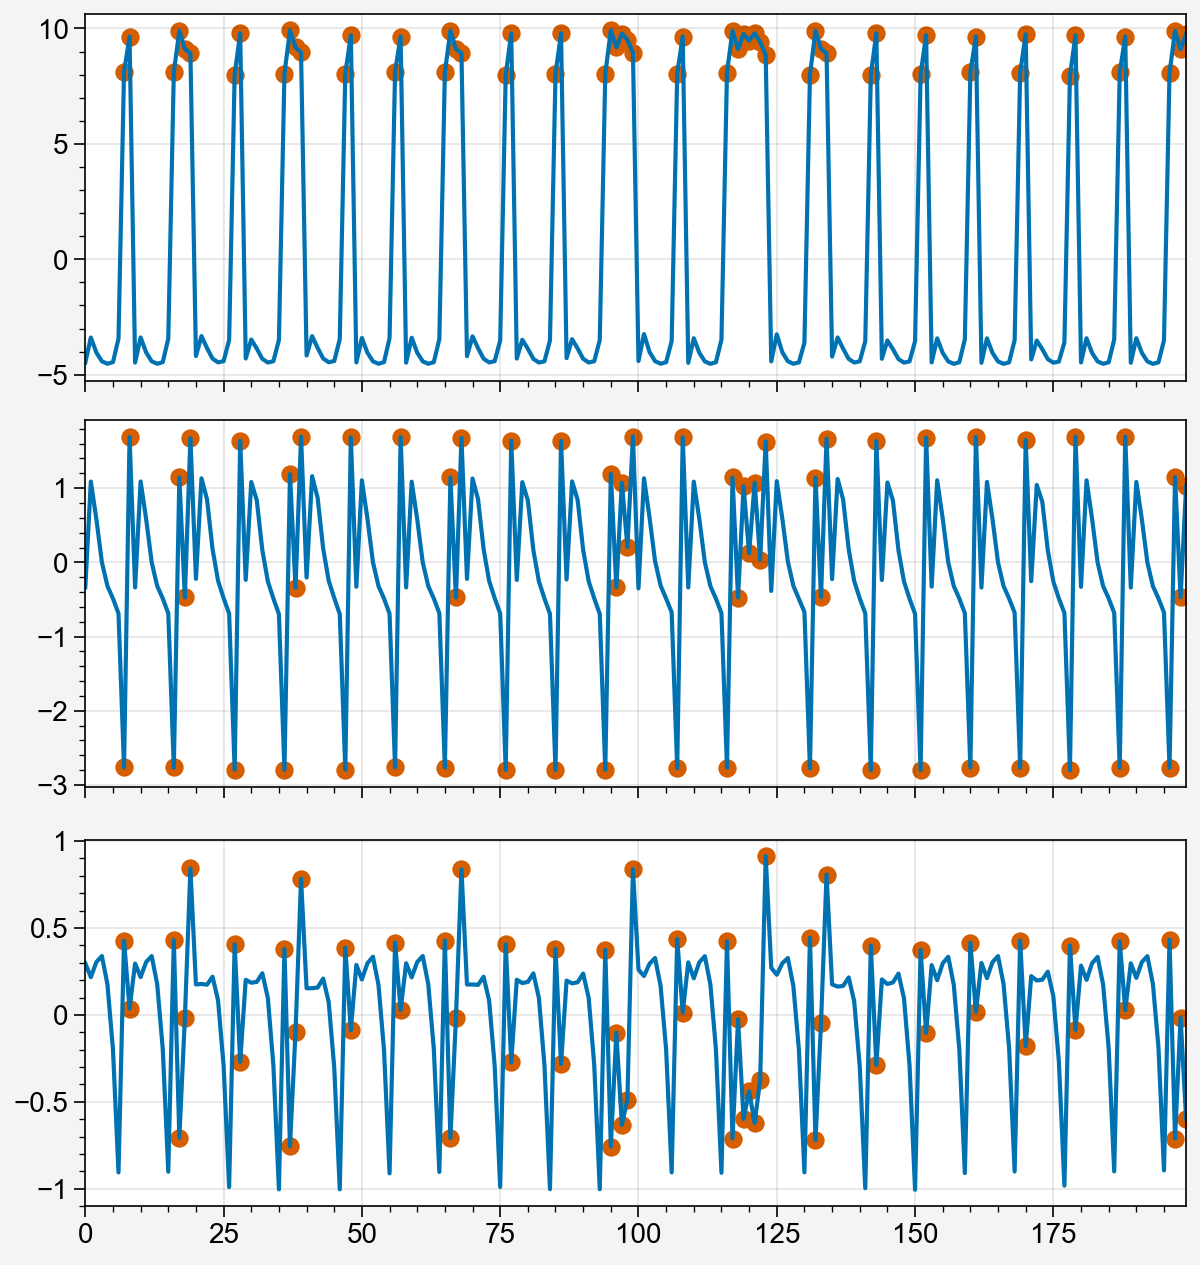

In [86]:
pca_as = comb_pca(res, 'actor1')
fig, ax = pplt.subplots(nrows=3, refaspect=3, figwidth=6)
ep = 0
a_idxs = np.argwhere(res['actions'][ep][200:400].reshape(-1)).reshape(-1)
for i in range(3):
    ax[i].plot(pca_as[0][200:400, i])
    ax[i].scatter(a_idxs, pca_as[ep][200+a_idxs, i])

In [152]:
def color_timesteps(res, ax, x, yline=1, ep=0):
    '''
    Generate color lines to indicate what color balloon was being run
    '''
    passive = res['data']['passive'][ep]
    balloon_steps = res['data']['balloon_step'][ep]
    colors = res['data']['current_color'][ep]
    
    x = np.arange(200, 400)
    start = np.argmax(balloon_steps > x[0]) - 1
    end = np.argmax(balloon_steps > x[-1])
    for i in range(start, end):
        x1 = max(x[0], balloon_steps[i])
        x2 = min(x[-1], balloon_steps[i+1])
        c = bart_plot_colors[colors[i]]
        if passive[i]:
            ls = '--'
        else:
            ls = '-'
        ax.plot([x1, x2], [yline, yline], c=c, ls=ls)
    

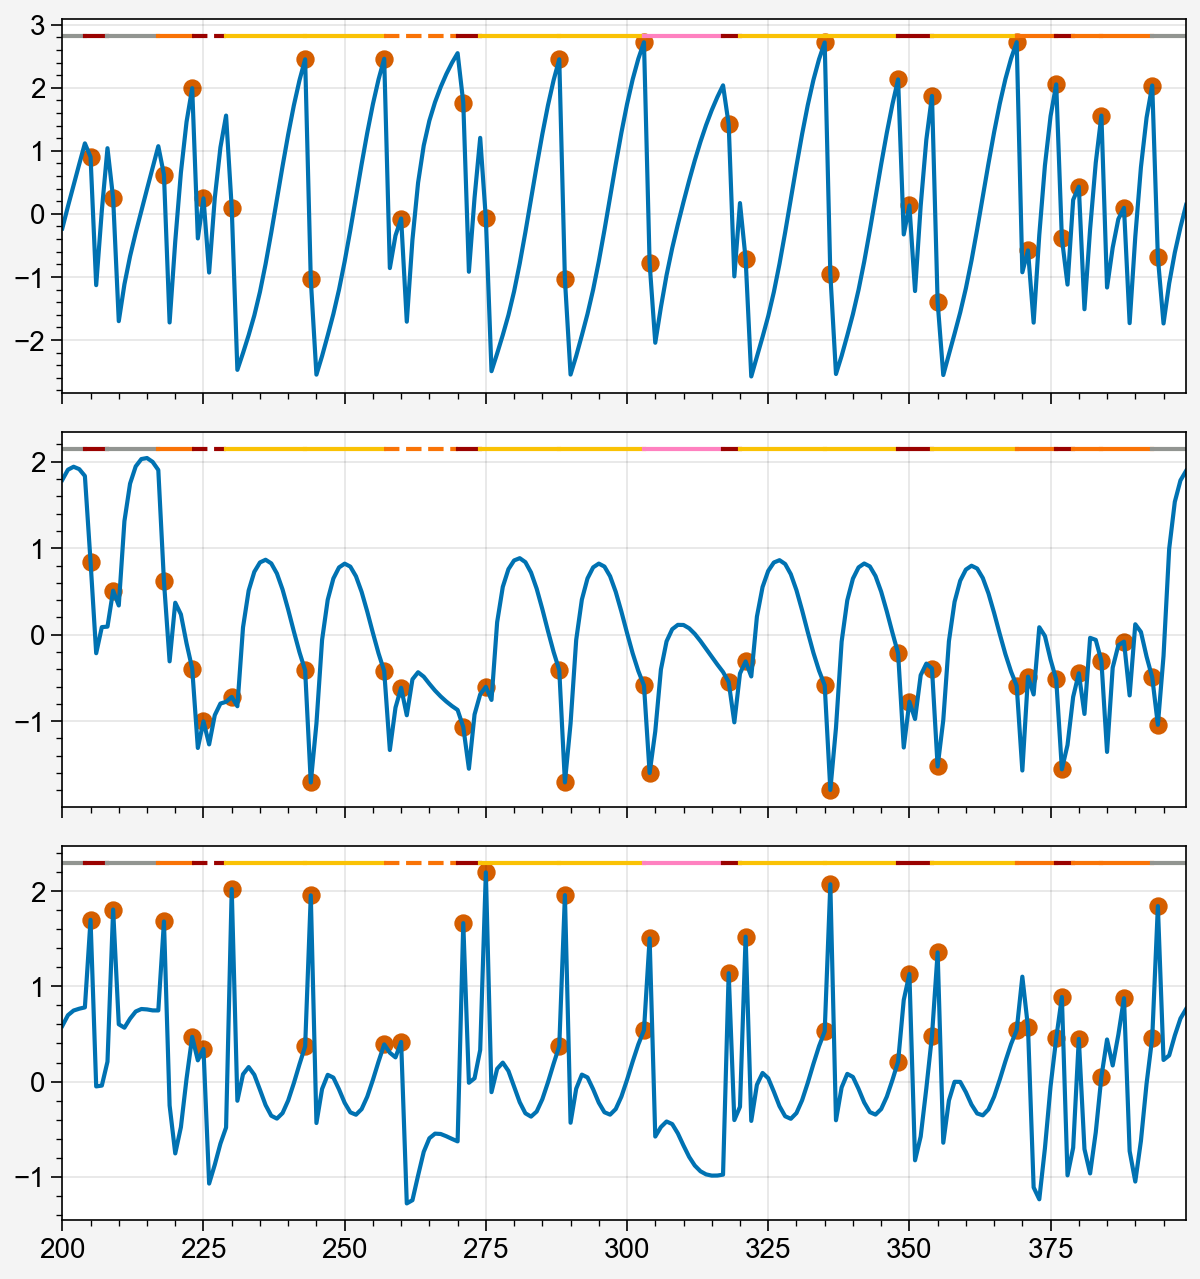

In [155]:
pca_as = comb_pca(res, 'shared1')
fig, ax = pplt.subplots(nrows=3, refaspect=3, figwidth=6)
ep = 0
x = np.arange(200, 400)
a_idxs = x[0] + np.argwhere(res['actions'][ep][x].reshape(-1)).reshape(-1)
for i in range(3):
    ax[i].plot(x, pca_as[0][x, i])
    ax[i].scatter(a_idxs, pca_as[ep][a_idxs, i])
    color_timesteps(res, ax[i], x, yline=0.1+np.max(pca_as[ep][x, i]))

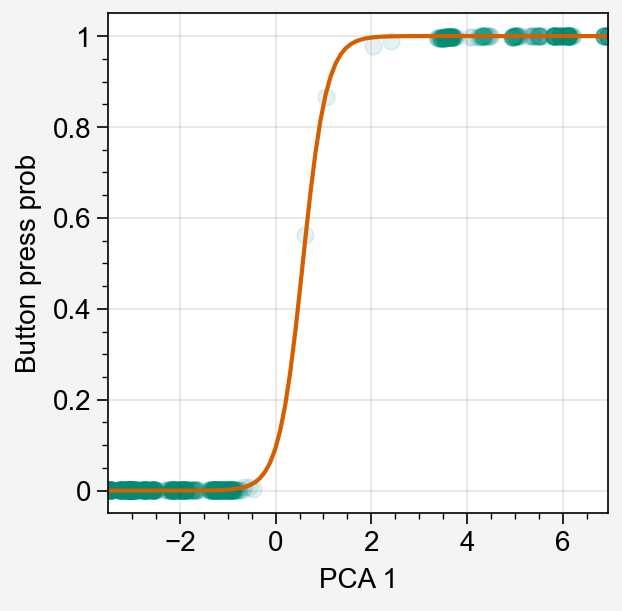

In [88]:
_ = fit_ramp(res, plot=True)

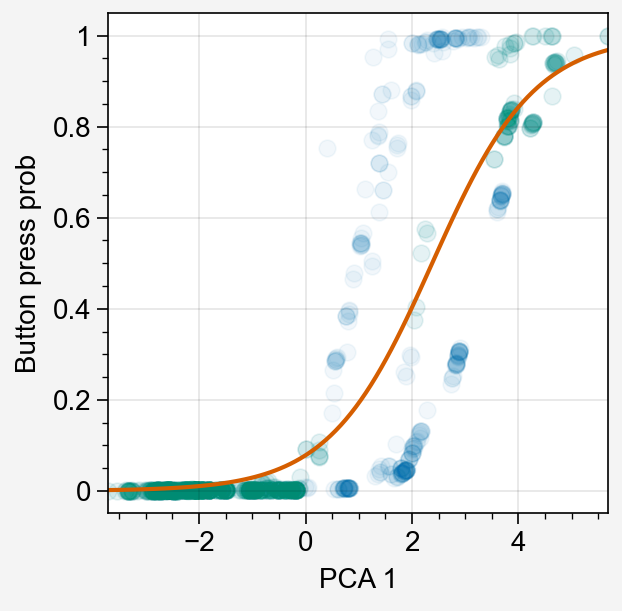

In [103]:
_ = fit_ramp(res, plot=True)

(array([ 28., 149., 190., 264., 154.,  85.,  21.,  24.,  29.,   6.]),
 array([-1.40825605, -1.01653761, -0.62481917, -0.23310073,  0.1586177 ,
         0.55033614,  0.94205458,  1.33377302,  1.72549145,  2.11720989,
         2.50892833]),
 <BarContainer object of 10 artists>)

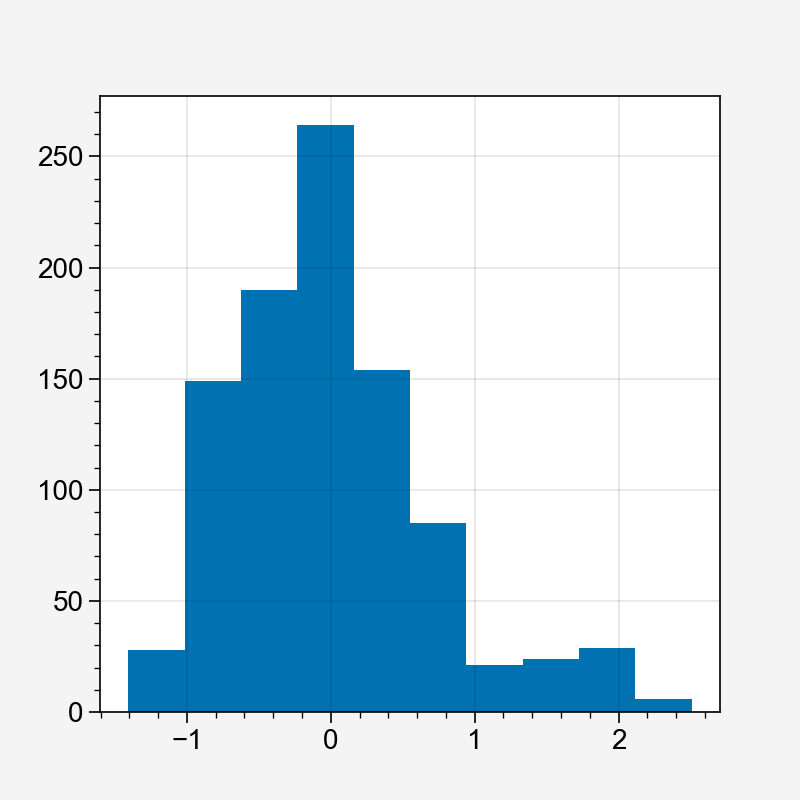

In [163]:
pca_as = comb_pca(res, 'shared1')[0]
plt.hist(pca_as[:, 2])

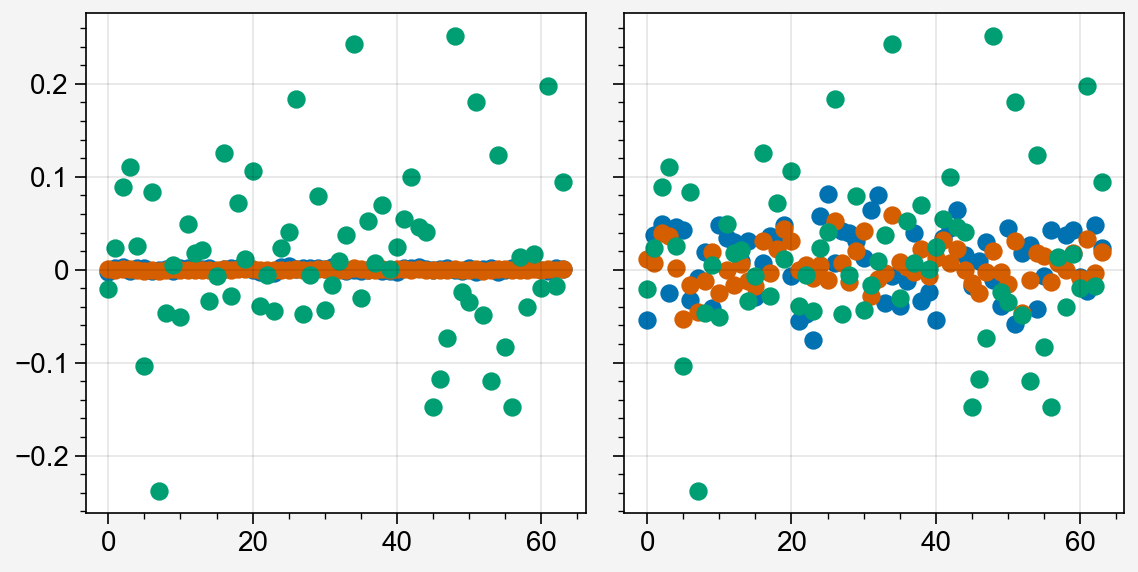

In [64]:
fig, ax = pplt.subplots(ncols=2)

delt_actor0 = measure_rnn_influence(res, model, ep, step)
ax[0].scatter(delt_actor0[decision_nodes].mean(axis=0))
ax[0].scatter(delt_actor0[~decision_nodes].mean(axis=0))
ax[0].scatter(actor0diff)

delt_actor0 = measure_rnn_influence(res, model, ep, step, decision_nodes=decision_nodes)
ax[1].scatter(delt_actor0[0])
ax[1].scatter(delt_actor0[1])
ax[1].scatter(actor0diff)

<a list of 1 Line2D objects>

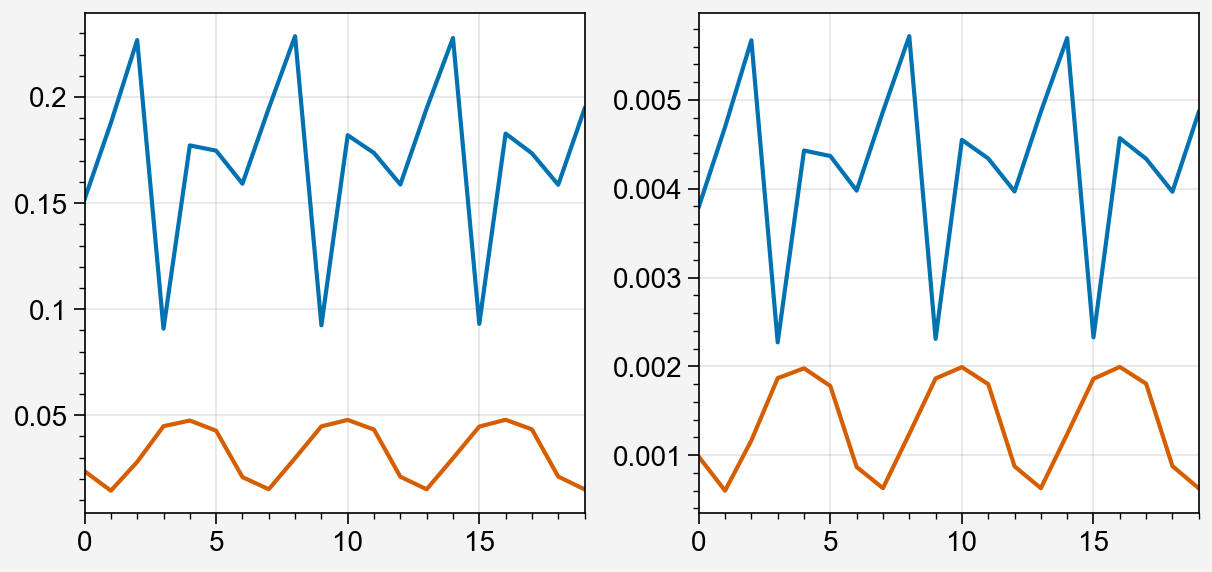

In [76]:
ep = 5
decision_nodes = find_decision_nodes(res, model, ep)
dec = []
nondec = []
for step in range(200, 220):
    delt_actor = measure_rnn_influence(res, model, ep, step, decision_nodes=decision_nodes)
    dec.append(delt_actor[0].abs().mean())
    nondec.append(delt_actor[1].abs().mean())
    
fig, ax = pplt.subplots(ncols=2, sharey=False)
ax[0].plot(dec)
ax[0].plot(nondec)
ax[1].plot(np.array(dec) / decision_nodes.sum())
ax[1].plot(np.array(nondec) / (~decision_nodes).sum())

<a list of 1 Line2D objects>

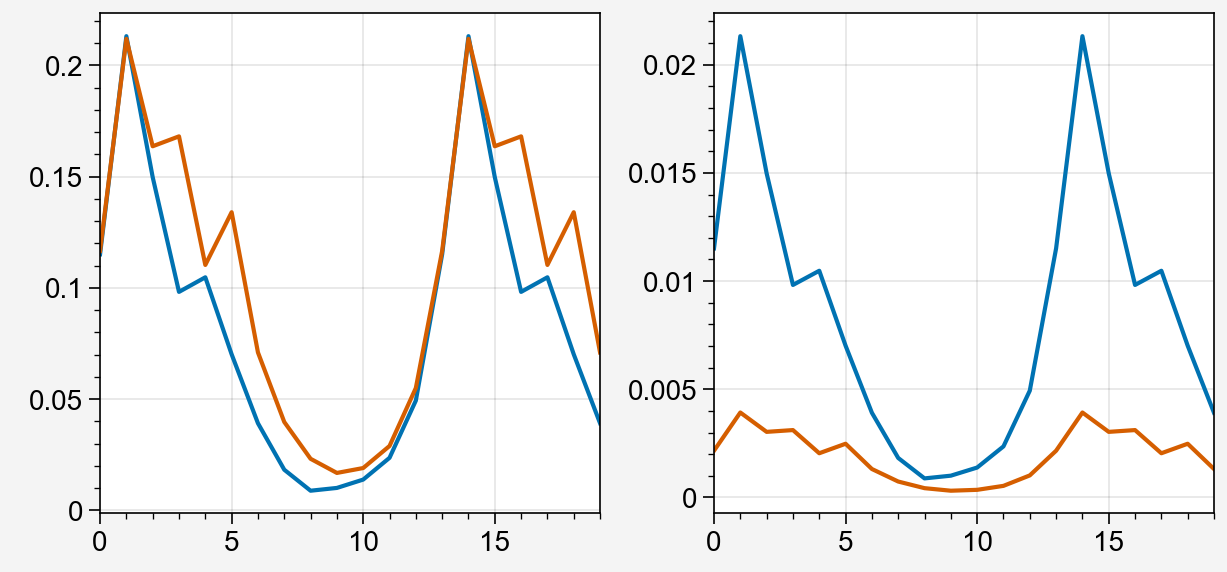

In [75]:
ep = 10
decision_nodes = find_decision_nodes(res, model, ep)
dec = []
nondec = []
for step in range(200, 220):
    delt_actor = measure_rnn_influence(res, model, ep, step, decision_nodes=decision_nodes)
    dec.append(delt_actor[0].abs().mean())
    nondec.append(delt_actor[1].abs().mean())
    
fig, ax = pplt.subplots(ncols=2, sharey=False)
ax[0].plot(dec)
ax[0].plot(nondec)
ax[1].plot(np.array(dec) / decision_nodes.sum())
ax[1].plot(np.array(nondec) / (~decision_nodes).sum())

(array([ 3.,  0.,  3., 14., 13., 10., 10.,  5.,  4.,  2.]),
 array([-0.05328411, -0.0420597 , -0.03083529, -0.01961087, -0.00838646,
         0.00283795,  0.01406236,  0.02528677,  0.03651118,  0.04773559,
         0.05896001], dtype=float32),
 <BarContainer object of 10 artists>)

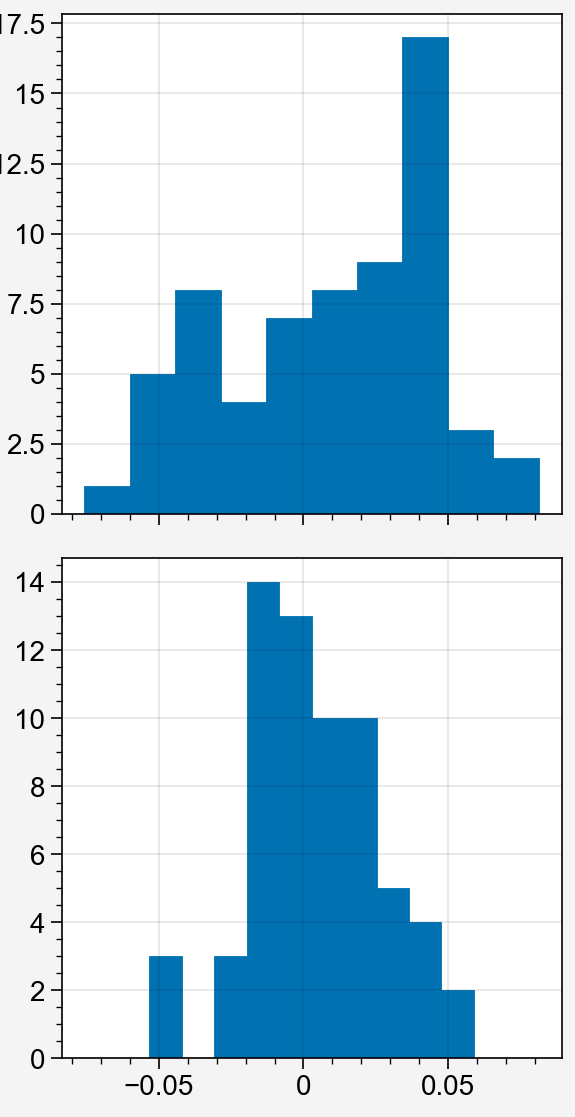

In [68]:
fig, ax = pplt.subplots(nrows=2)
ax[0].hist(delt_actor0[0])
ax[1].hist(delt_actor0[1])

(array([15., 13., 11.,  8.,  3.,  5.,  3.,  3.,  1.,  2.]),
 array([0.00010216, 0.00598795, 0.01187373, 0.01775951, 0.0236453 ,
        0.02953108, 0.03541687, 0.04130265, 0.04718844, 0.05307422,
        0.05896001], dtype=float32),
 <BarContainer object of 10 artists>)

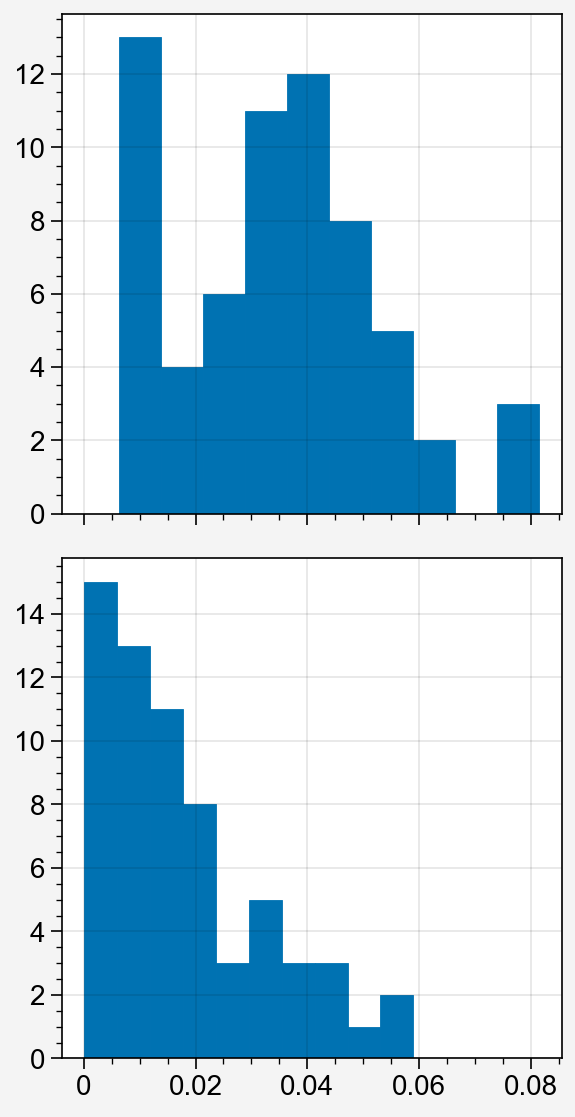

In [69]:
fig, ax = pplt.subplots(nrows=2)
ax[0].hist(delt_actor0[0].abs())
ax[1].hist(delt_actor0[1].abs())

# Decision node consistency

In [59]:
measure_rnn_influence(res, model, 11, 200, large_kick=True)

tensor([[ 0.0103,  0.3825,  0.1010,  ...,  0.0055,  0.0429, -0.0402],
        [ 0.2604, -0.2178, -0.0561,  ...,  0.0364, -0.0919,  0.1827],
        [-0.1569,  0.0869, -0.0472,  ..., -0.0238,  0.2794, -0.1733],
        ...,
        [ 0.0970,  0.1866, -0.0596,  ..., -0.0034,  0.3945,  0.1005],
        [-0.0102,  0.1894,  0.0804,  ...,  0.0127,  0.0671, -0.3429],
        [-0.2160, -0.1706,  0.0192,  ..., -0.0183,  0.1963, -0.0544]])

In [51]:
num_dec_nodes = []
for ep in range(17):
    decision_nodes = find_decision_nodes(res, model, ep)
    num_dec_nodes.append(decision_nodes.sum())
    

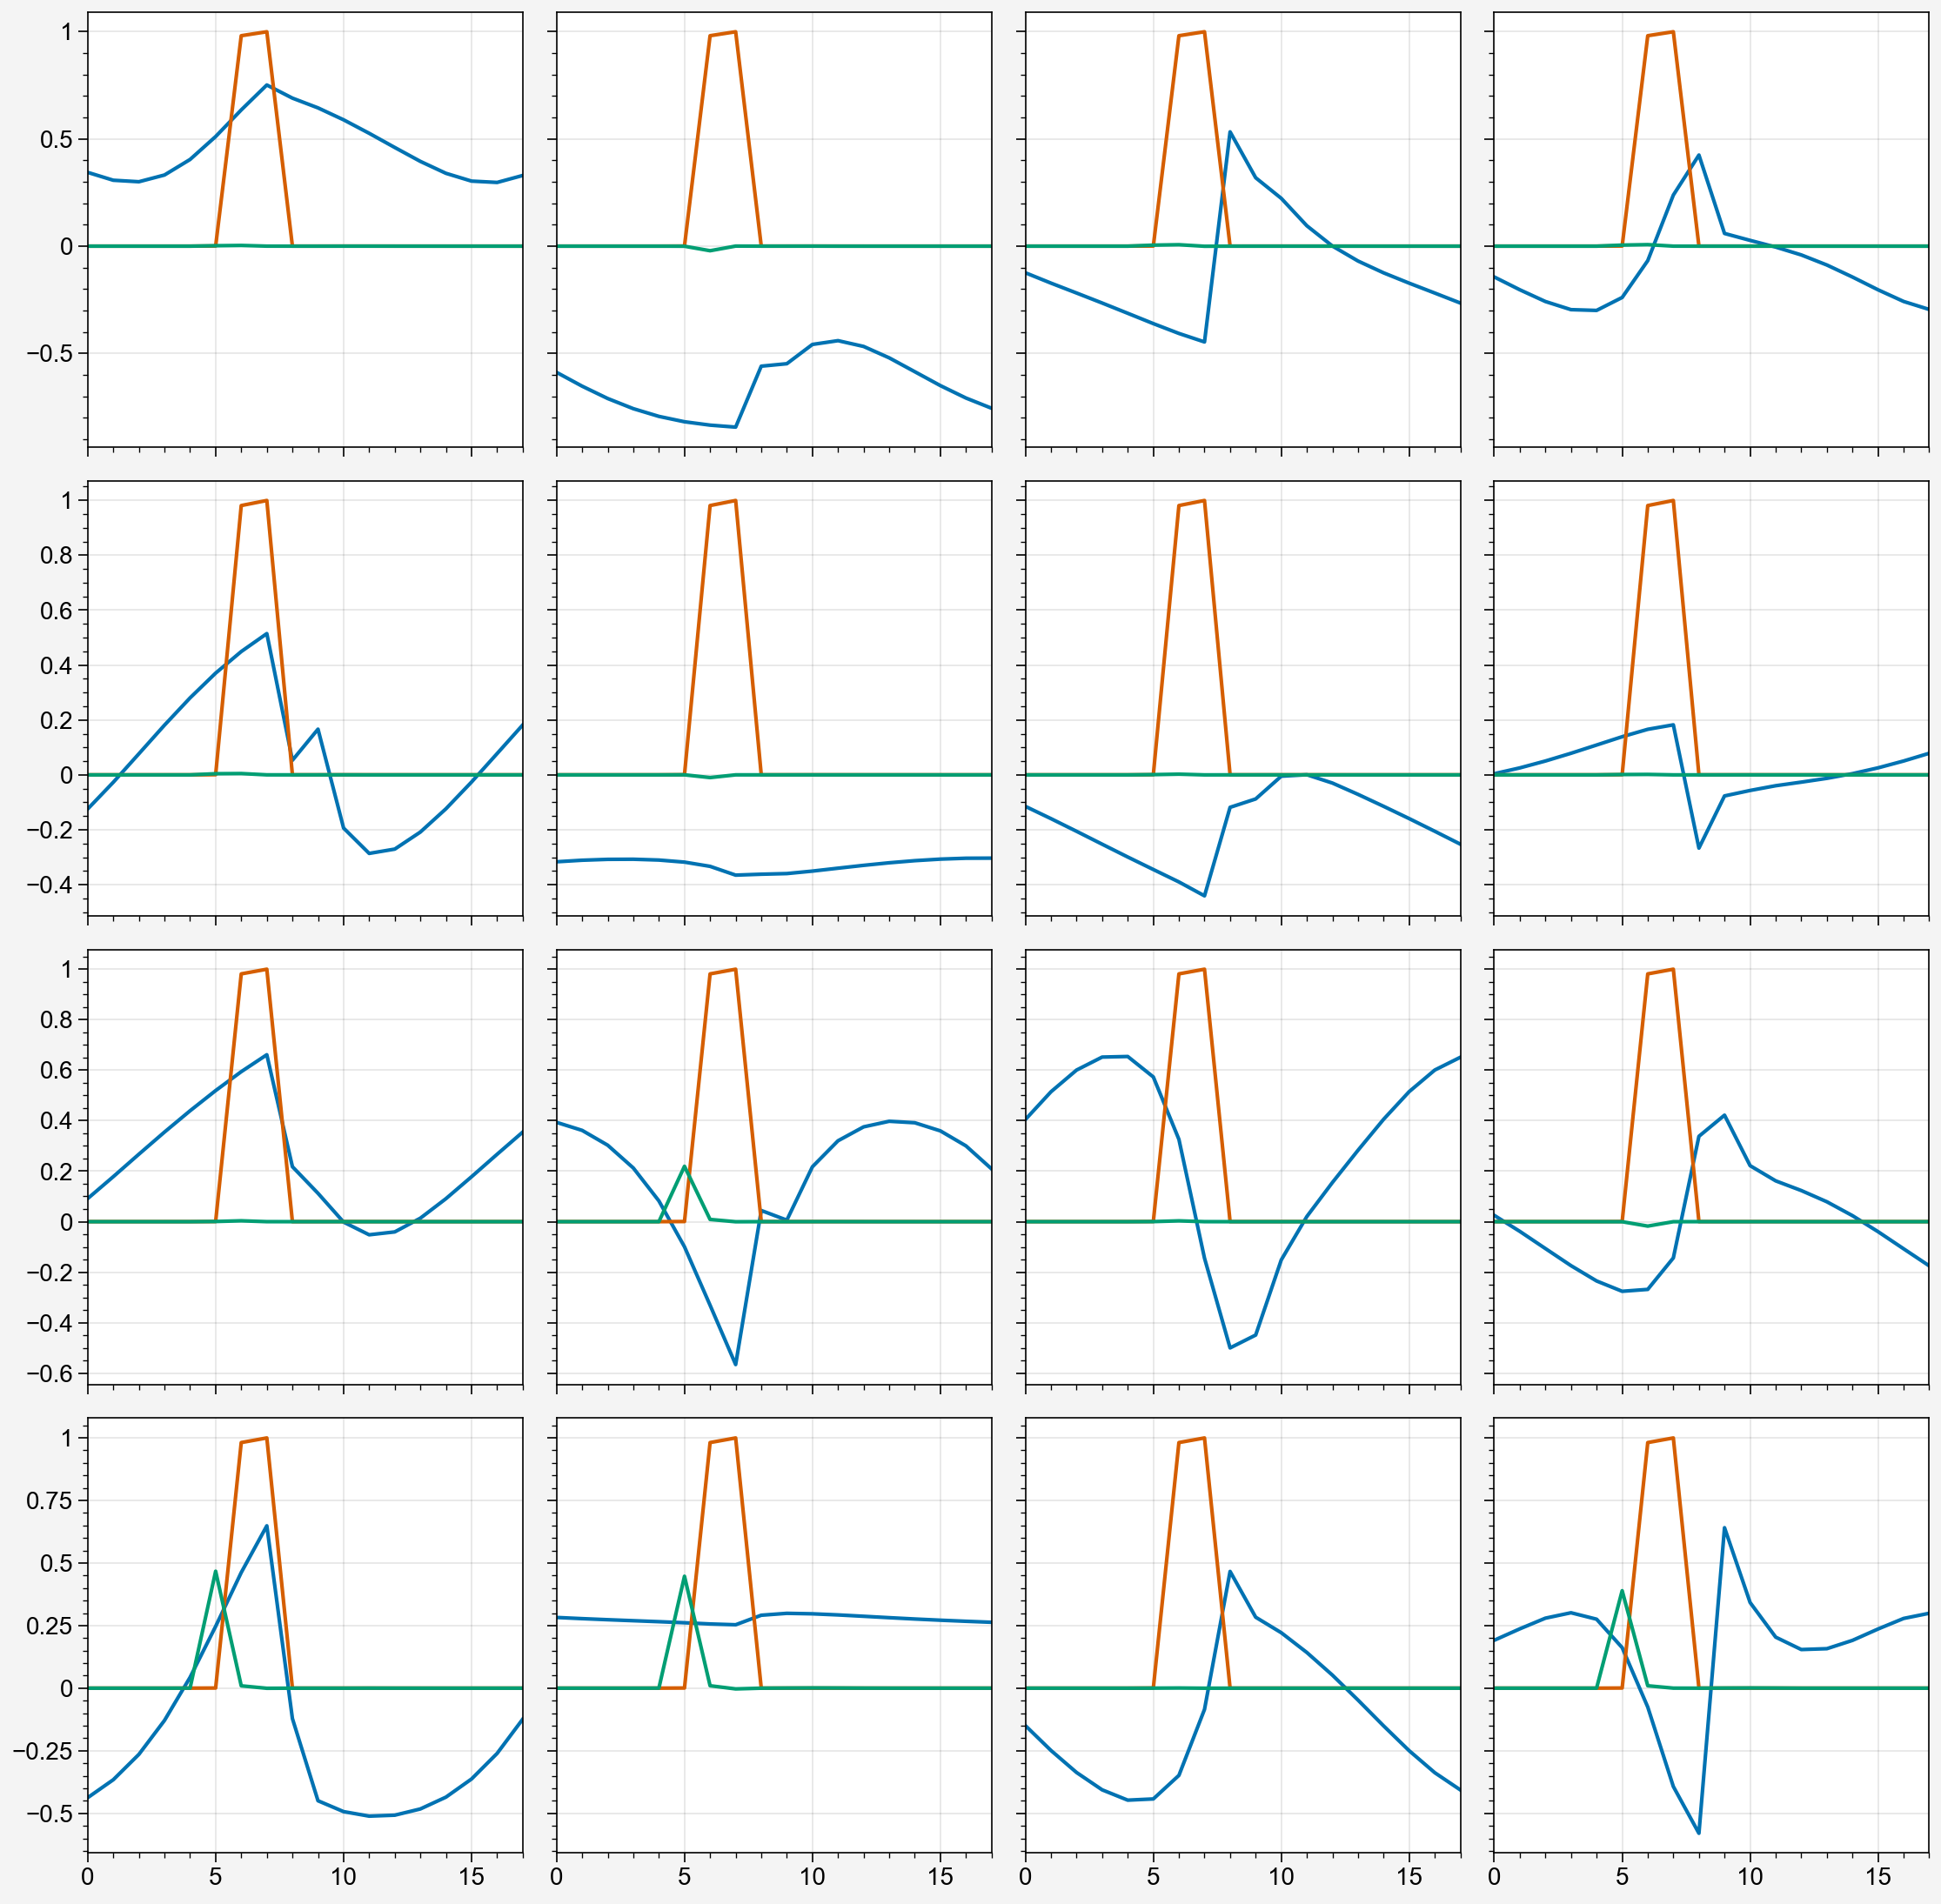

In [61]:

fig, ax = pplt.subplots(nrows=4, ncols=4)
step1 = 202
step2 = 220
steps = range(step1, step2)
aps = np.zeros((len(steps), 64))
for i, step in enumerate(steps):
    _, ap = measure_rnn_influence(res, model, ep, step, ap=True, large_kick=True)
    aps[i] = ap[:, 1].detach()
    
rnn_hxs = res['rnn_hxs'][ep][step1:step2]
ap = res['action_probs'][ep][step1:step2][:, 1]
for i in range(16):
    ax[i].plot(rnn_hxs[:, i])
    ax[i].plot(ap)
    ax[i].plot(aps[:, i] - ap)

In [4]:
size = np.arange(0.2, 1.01, 0.05)
env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 40,
                            'inflate_noise': 0,
                            'fix_sizes': [0, s, 0]} for s in size]

evalu = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=env_kwargs, 
                num_processes=17,
                seed=1,
                deterministic=False,
                with_activations=True)

In [84]:
model_types = [
    1.2, 1.5, 1.7, 2
]
punish_types = [
    2, "2long"
]

model = model_types[0]
t = 0
exp_name = f"p{model}n50"
chk = 50

model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=40)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


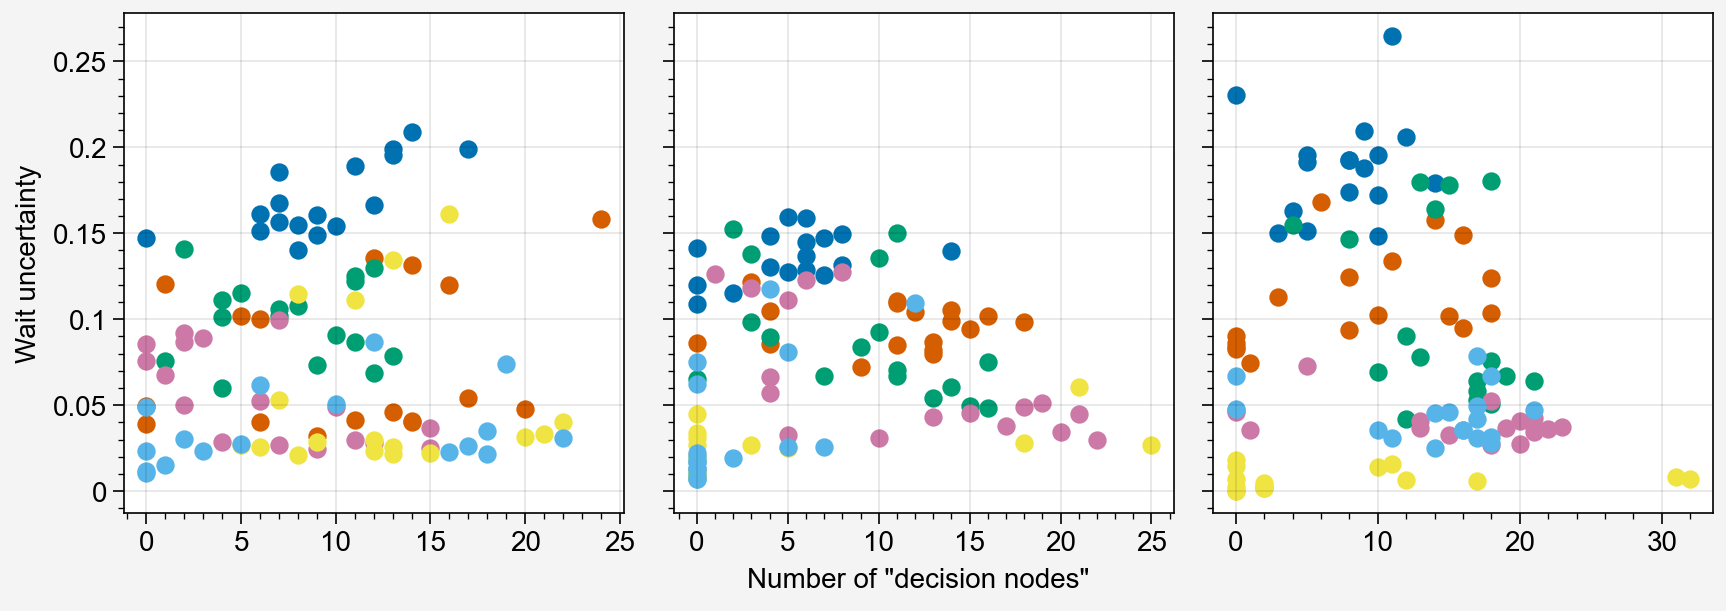

In [158]:
chks = np.arange(40, 243, 40)
trials = range(3)

fig, ax = pplt.subplots(ncols=3)

for t in trials:
    for chk in chks:
        model, (obs_rms, ret_rms) = \
            torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
        res = evalu(model, obs_rms)
        res = reshape_parallel_evalu_res(res, meta_balloons=40)

        num_dec_nodes = []
        non_press_probs = []
        for ep in range(17):
            decision_nodes = find_decision_nodes_efficient(res, model, ep)
            num_dec_nodes.append(decision_nodes.sum())
            
            p = np.array(res['action_probs'][ep])[~(res['actions'][ep].reshape(-1) == 1)][:, 1]
            non_press_probs.append(p.mean())
        
        ax[t].scatter(num_dec_nodes, non_press_probs)

ax.format(xlabel='Number of "decision nodes"', ylabel='Wait uncertainty')

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


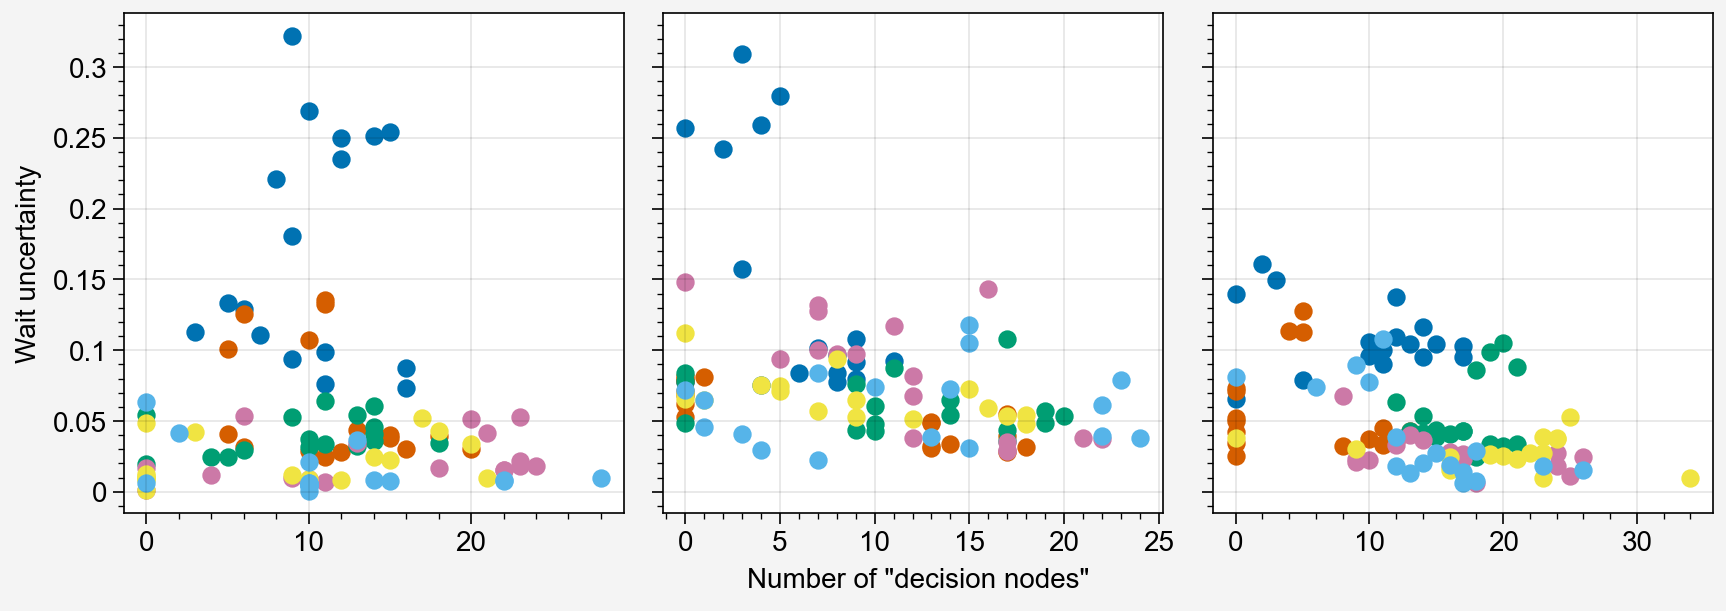

In [159]:
model = 1.7
exp_name = f"p{model}n50"

chks = np.arange(40, 243, 40)
trials = range(3)

fig, ax = pplt.subplots(ncols=3)

for t in trials:
    for chk in chks:
        model, (obs_rms, ret_rms) = \
            torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
        res = evalu(model, obs_rms)
        res = reshape_parallel_evalu_res(res, meta_balloons=40)

        num_dec_nodes = []
        non_press_probs = []
        for ep in range(17):
            decision_nodes = find_decision_nodes_efficient(res, model, ep)
            num_dec_nodes.append(decision_nodes.sum())
            
            p = np.array(res['action_probs'][ep])[~(res['actions'][ep].reshape(-1) == 1)][:, 1]
            non_press_probs.append(p.mean())
        
        ax[t].scatter(num_dec_nodes, non_press_probs)

ax.format(xlabel='Number of "decision nodes"', ylabel='Wait uncertainty')

In [171]:
np.mean(all_non_probs[model][t], axis=0)

array([0.085596  , 0.08775943, 0.08930539, 0.06149393, 0.05864492,
       0.04508759, 0.0414736 , 0.03821367, 0.04115169, 0.0376647 ,
       0.03947894, 0.04404339, 0.04837698, 0.03828644, 0.04772415,
       0.04236461, 0.03918055], dtype=float32)

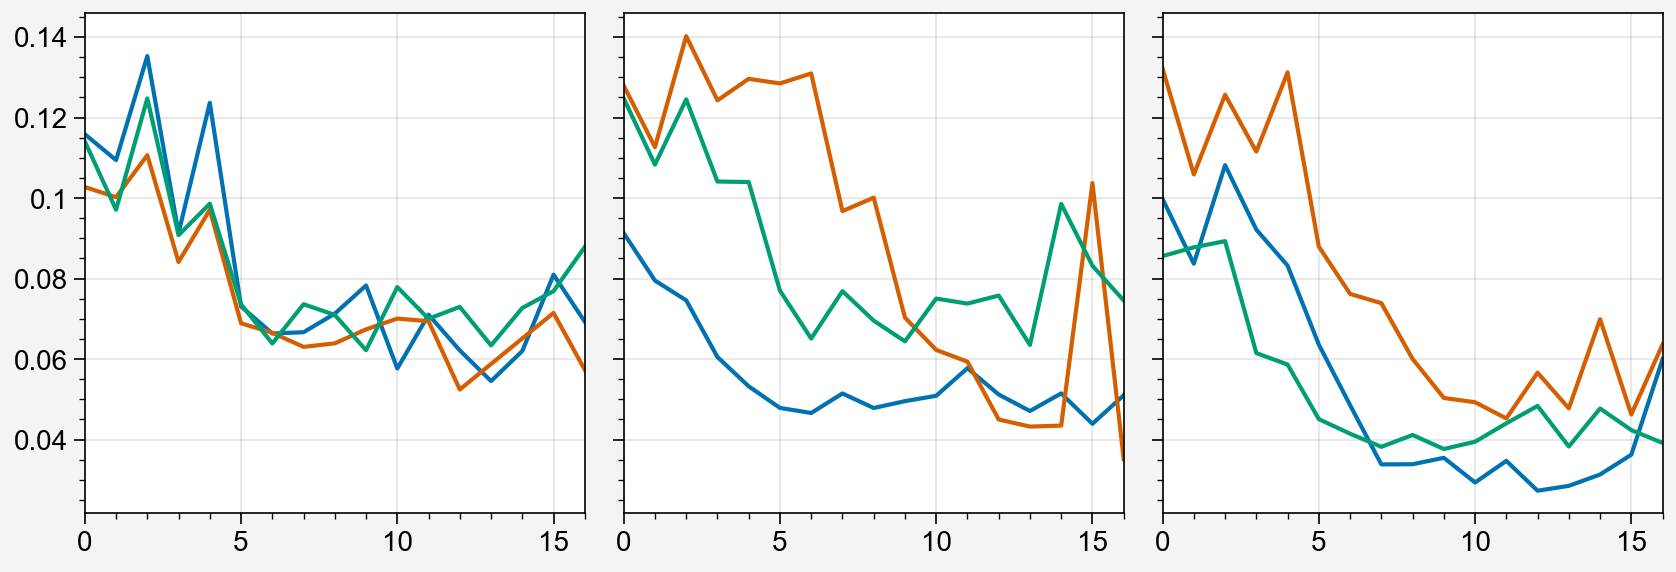

In [172]:
fig, ax = pplt.subplots(ncols=3)
for i, model in enumerate([1.2, 1.5, 1.7]):
    for t in trials:
        ax[i].plot(np.mean(all_non_probs[model][t], axis=0))

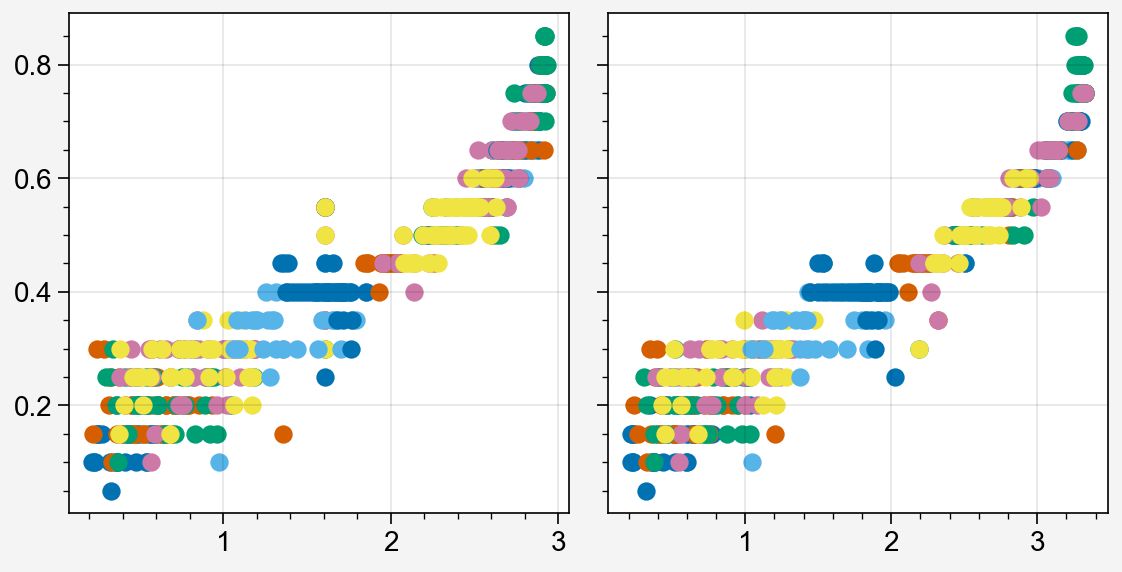

In [253]:
fig, ax = pplt.subplots(ncols=2)
for ep in range(17):
    
    end_sizes = (ends[ep] - starts[ep]) * 0.05
    values = res['values'][ep][starts[ep]]
    ax[0].scatter(values, end_sizes)
    values = res['values'][ep][ends[ep]]
    ax[1].scatter(values, end_sizes)

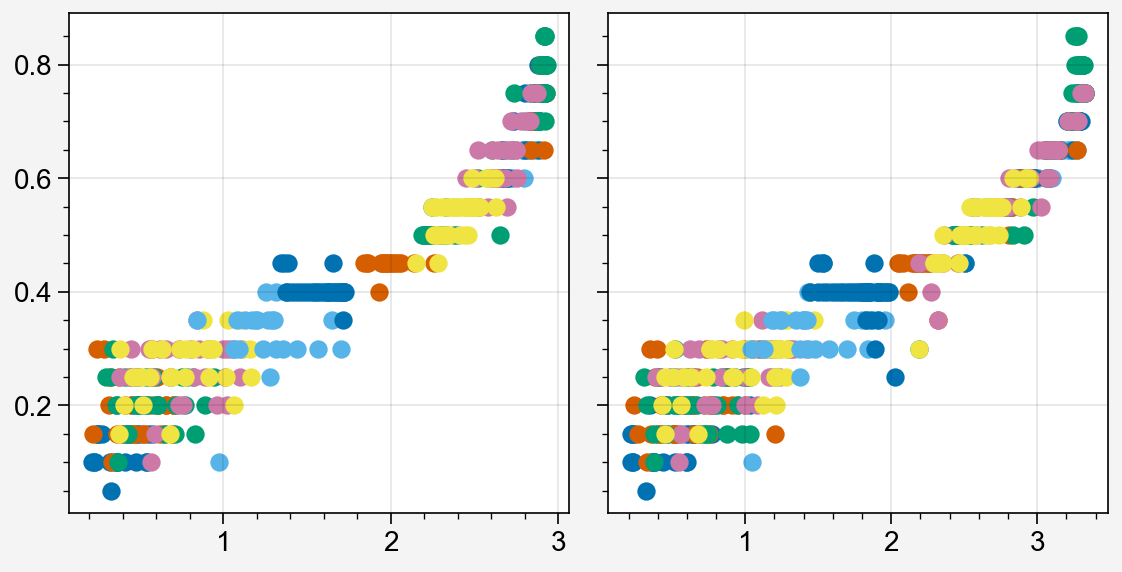

In [254]:
fig, ax = pplt.subplots(ncols=2)
for ep in range(17):
    
    end_sizes = (ends[ep] - starts[ep]) * 0.05
    values = res['values'][ep][starts[ep]]
    ax[0].scatter(values[10:], end_sizes[10:])
    values = res['values'][ep][ends[ep]]
    ax[1].scatter(values, end_sizes)

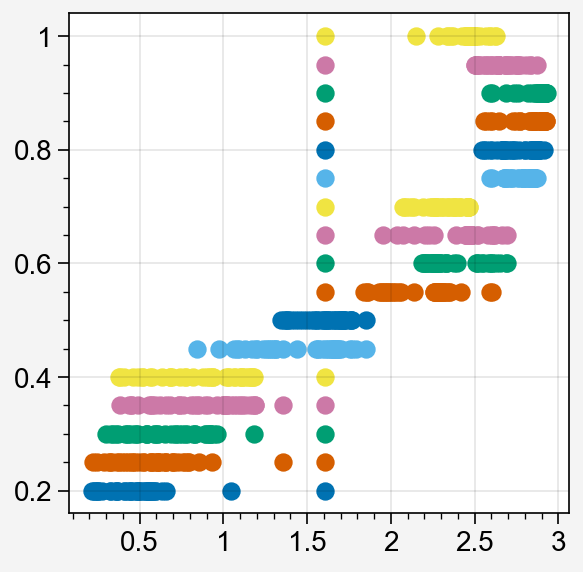

In [260]:
fig, ax = pplt.subplots()
for ep in range(17):
    
    values = res['values'][ep][starts[ep]]
    balloon_means = res['data']['balloon_means'][ep][1]
    balloon_means = np.full(len(values), balloon_means)
    ax.scatter(values, balloon_means)

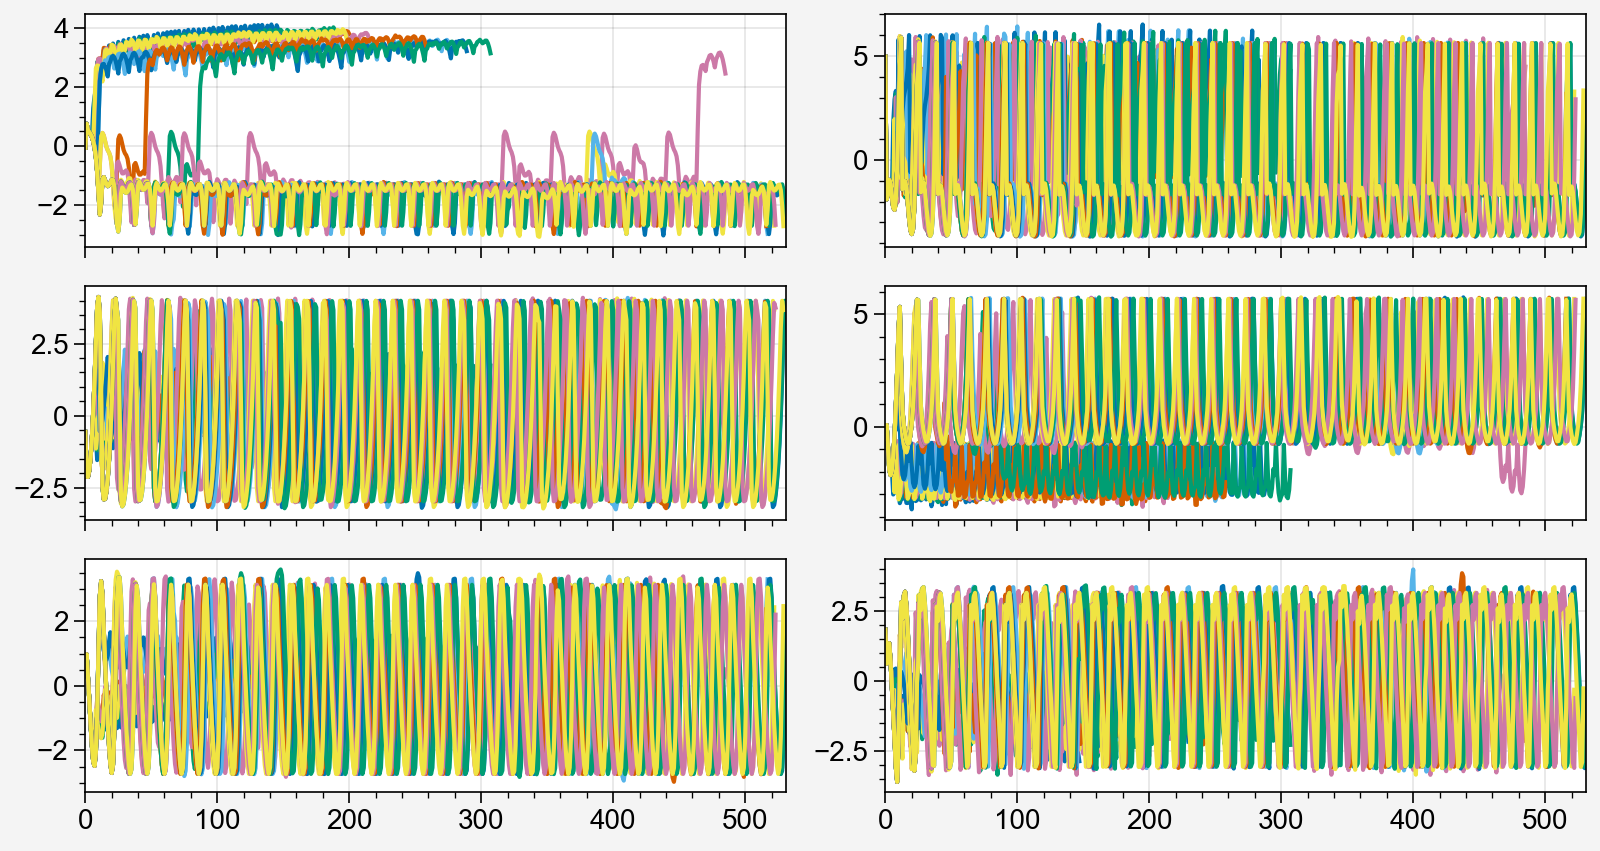

In [354]:
fig, ax = pplt.subplots(refaspect=3, figwidth=8, nrows=3, ncols=2, sharey=False)
pca_as = comb_pca(res)
for ep in range(17):
    ax[0, 0].plot(pca_as[ep][:, 0])
    ax[1, 0].plot(pca_as[ep][:, 1])
    ax[2, 0].plot(pca_as[ep][:, 2])
    
pca_as = comb_pca(res, 'actor0')
for ep in range(17):
    ax[0, 1].plot(pca_as[ep][:, 0])
    ax[1, 1].plot(pca_as[ep][:, 1])
    ax[2, 1].plot(pca_as[ep][:, 2])

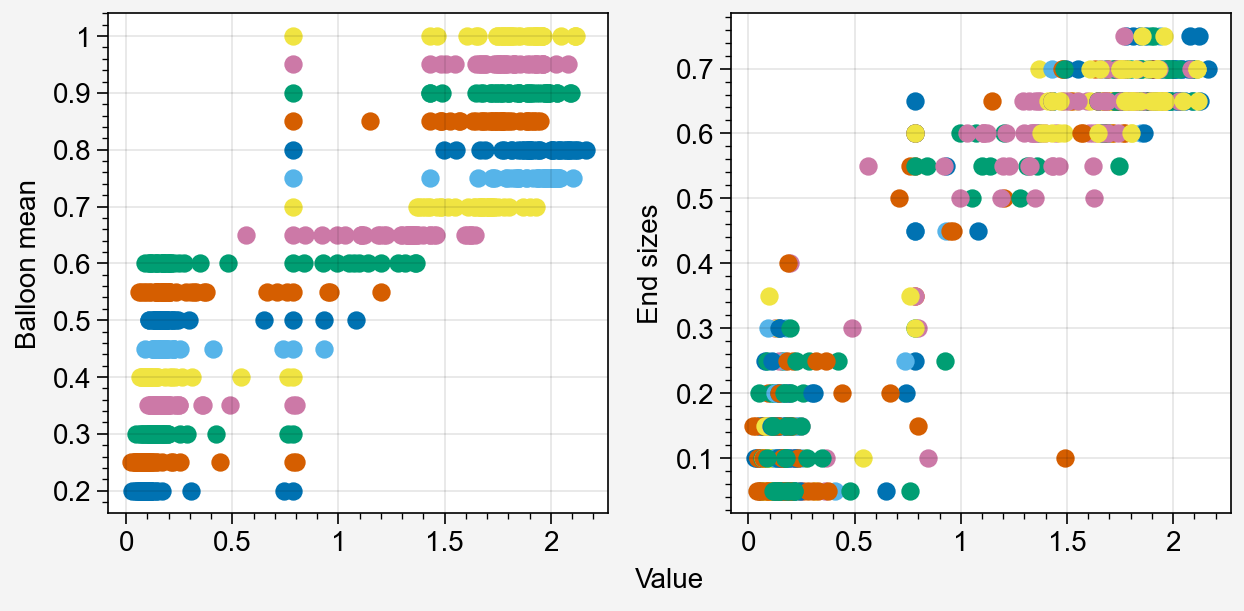

In [272]:
starts, ends = starts_and_ends(res)

fig, ax = pplt.subplots(ncols=2, sharey=False)
for ep in range(17):
    
    values = res['values'][ep][starts[ep]]
    end_sizes = (ends[ep] - starts[ep]) * 0.05
    balloon_means = res['data']['balloon_means'][ep][1]
    balloon_means = np.full(len(values), balloon_means)
    ax[0].scatter(values, balloon_means)
    ax[1].scatter(values, end_sizes)


ax[0].format(xlabel='Value', ylabel='Balloon mean')
ax[1].format(ylabel='End sizes')

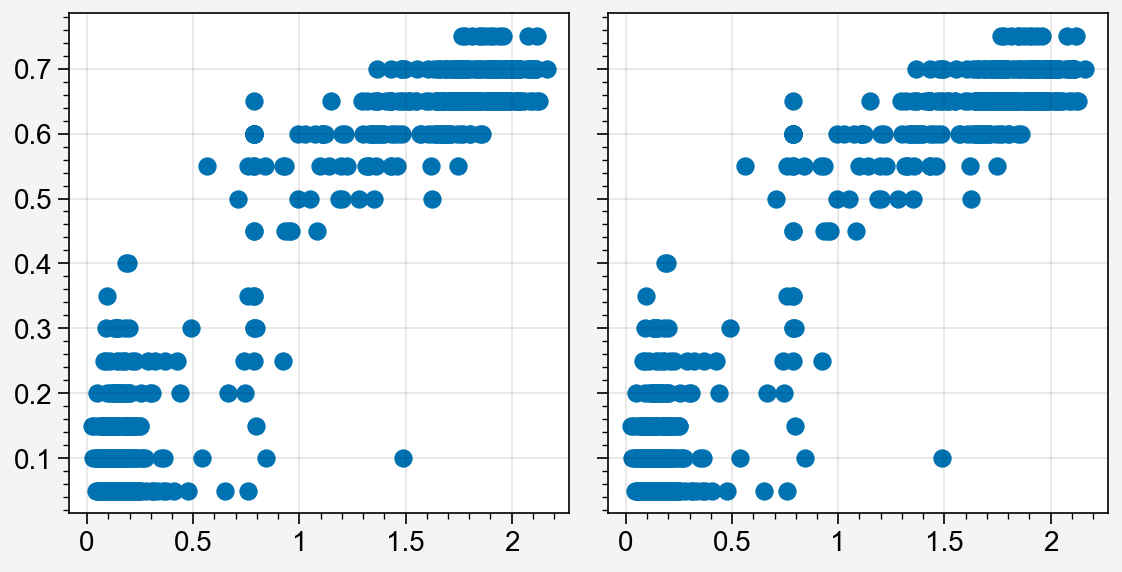

In [295]:
starts, ends = starts_and_ends(res)
sizes1 = np.concatenate(np.vstack(ends) - np.vstack(starts))*0.05
sizes = get_sizes(res, obs_rms)
sizes2 = []
for ep in range(17):
    sizes2.append(sizes[ep][ends[ep]])
sizes2 = np.concatenate(sizes2)
values = np.vstack(res['values']).reshape(-1)
values = np.vstack([res['values'][ep][starts[ep]] for ep in range(17)]).reshape(-1)
fig, ax = pplt.subplots(ncols=2)
ax[0].scatter(values, sizes1)
ax[1].scatter(values, sizes2)

Text(0.1, 0.9, 'p=1: 0.909 \np=2: 0.931')

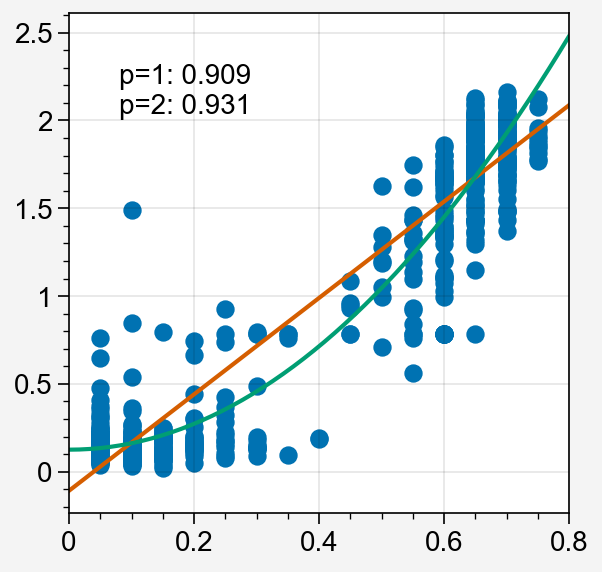

In [333]:
starts, ends = starts_and_ends(res)
sizes = np.concatenate(np.vstack(ends) - np.vstack(starts))*0.05
values = np.vstack([res['values'][ep][starts[ep]] for ep in range(17)]).reshape(-1)
fig, ax = pplt.subplots()
ax.scatter(sizes, values)

x = np.linspace(0, 0.8)
(m, b), linear_r2 = linear_best_fit(sizes, values)
ax.plot(x, m*x + b)
(m, b), p_r2 = p_best_fit(sizes, values, 2)
ax.plot(x, m*x**2 + b)

ax.text(0.1, 0.9, f'p=1: {linear_r2:.3f} \np=2: {p_r2:.3f}', va='top', ha='left',
        transform=ax.transAxes)


Text(0.1, 0.9, 'p=1: 0.944 \np=2: 0.966')

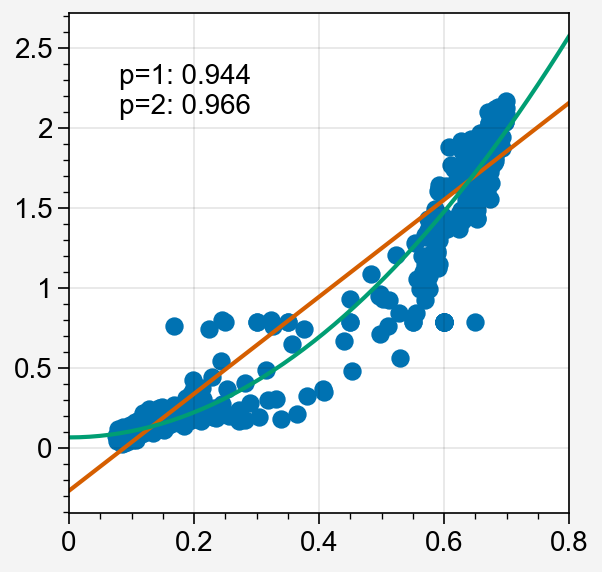

In [339]:
sizes = (np.vstack(ends) - np.vstack(starts))*0.05
sizes = np.concatenate([pd.Series(sizes[ep]).ewm(alpha=0.1).mean() for ep in range(17)])
values = np.vstack([res['values'][ep][starts[ep]] for ep in range(17)]).reshape(-1)
fig, ax = pplt.subplots()
ax.scatter(sizes, values)

x = np.linspace(0, 0.8)
(m, b), linear_r2 = linear_best_fit(sizes, values)
ax.plot(x, m*x + b)
(m, b), p_r2 = p_best_fit(sizes, values, 2)
ax.plot(x, m*x**2 + b)

ax.text(0.1, 0.9, f'p=1: {linear_r2:.3f} \np=2: {p_r2:.3f}', va='top', ha='left',
        transform=ax.transAxes)

Text(0.1, 0.9, 'p=1: 0.916 \np=2: 0.907')

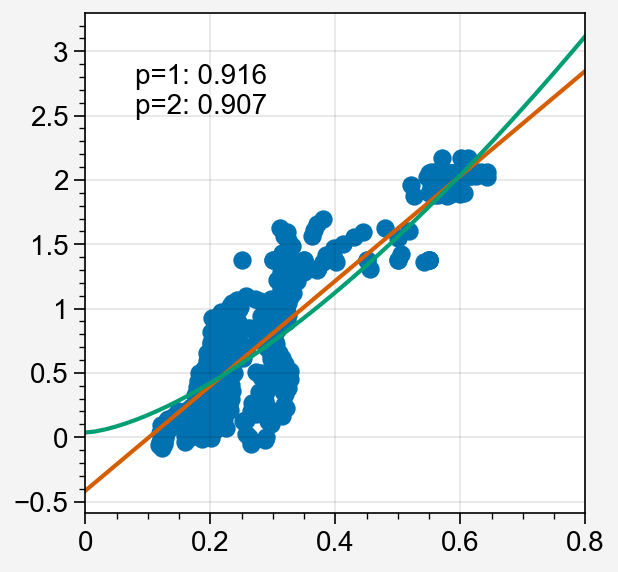

In [352]:
starts, ends = starts_and_ends(res)
sizes = (np.vstack(ends) - np.vstack(starts))*0.05
sizes = np.concatenate([pd.Series(sizes[ep]).ewm(alpha=0.1).mean() for ep in range(17)])
values = np.vstack([res['values'][ep][starts[ep]] for ep in range(17)]).reshape(-1)
fig, ax = pplt.subplots()
ax.scatter(sizes, values)

x = np.linspace(0, 0.8)
(m, b), linear_r2 = linear_best_fit(sizes, values)
ax.plot(x, m*x + b)
(m, b), p_r2 = p_best_fit(sizes, values, 1.5)
ax.plot(x, m*x**1.5 + b)

ax.text(0.1, 0.9, f'p=1: {linear_r2:.3f} \np=2: {p_r2:.3f}', va='top', ha='left',
        transform=ax.transAxes)

# Identify ramping signal

In [361]:

models = [
    1.0, 1.2, 1.5, 1.7, 2.0
]
postfixes = ['', 'pop0.1']

model = 1.5
t = 0
exp_name = f"p{model}n50pop0.1"
chk = 200

exp_name = f"p{model}n50"
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=40)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


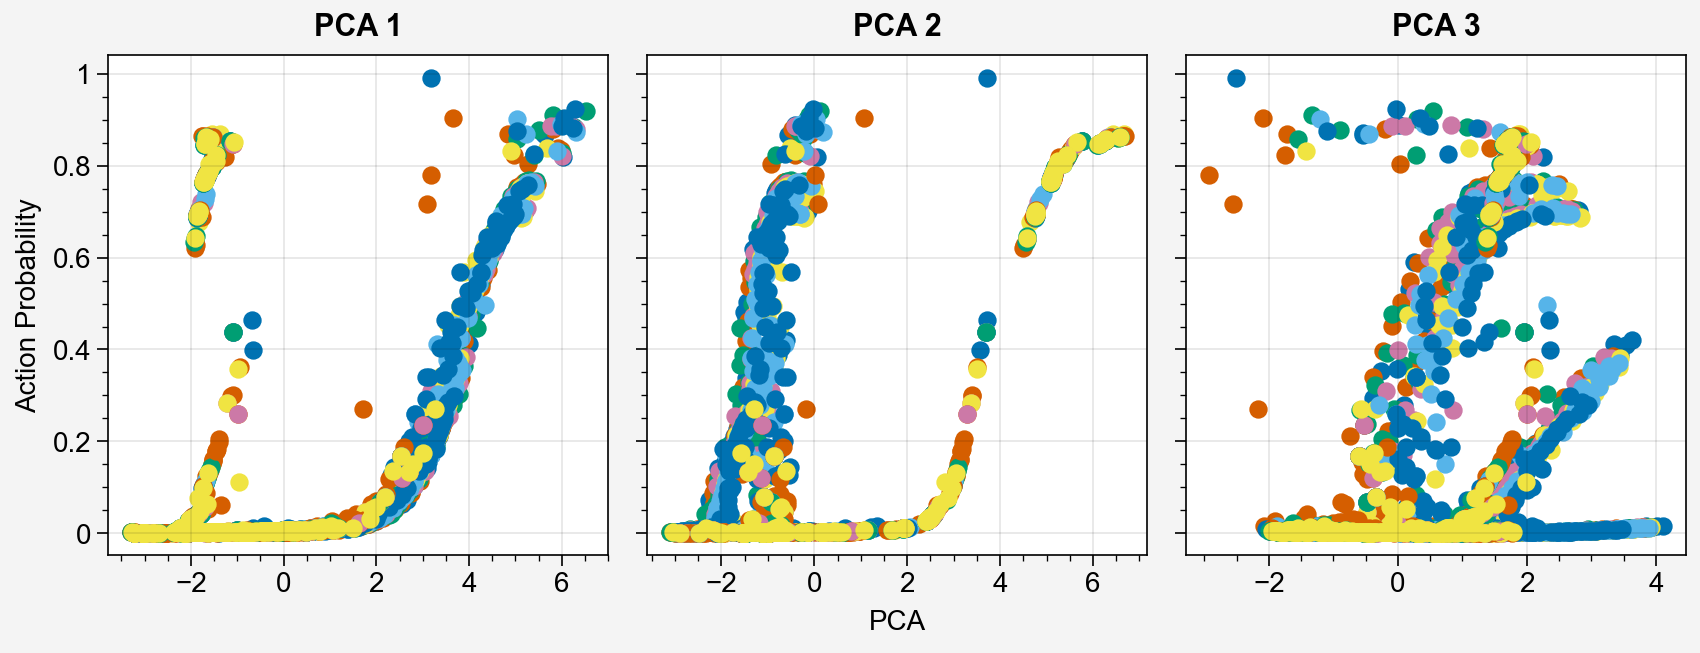

In [211]:
fig, ax = pplt.subplots(ncols=3)

pca_as = comb_pca(res, 'actor0')
starts, ends = starts_and_ends(res)

for ep in range(17):
    
    ap = res['action_probs'][ep][:, 1]
    idxs = np.full(len(ap), True)
    idxs[starts[ep]] = False
    pca_a = pca_as[ep]
    for i in range(3):
        # ax[i].scatter(pca_a[:, i], ap)
        ax[i].scatter(pca_a[idxs, i], ap[idxs])
        
ax.format(xlabel='PCA', ylabel='Action Probability',
          toplabels=['PCA 1', 'PCA 2', 'PCA 3'])

In [ ]:
import warnings
warnings.filterwarnings("ignore")

chks = np.arange(0, 243, 30)

iterators = [postfixes, models, range(3), chks]
sizes = [len(i) for i in iterators]
iterators_idxs = [range(len(i)) for i in iterators]

ramp_location = np.zeros(sizes)
ramp_r2 = np.zeros(sizes)
bimodal_rnn_location = np.zeros(sizes)
bimodal_rnn_score = np.zeros(sizes)
bimodal_actor_location = np.zeros(sizes)
bimodal_actor_score = np.zeros(sizes)

for i, j, k, l in tqdm(itertools.product(*iterators_idxs), total=np.prod(sizes)):
    try:
        postfix = postfixes[i]
        model = models[j]
        t = k
        chk = chks[l]
        
        exp_name = f"p{model}n50{postfix}"
        model, (obs_rms, ret_rms) = \
            torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
        res = evalu(model, obs_rms)
        res = reshape_parallel_evalu_res(res, meta_balloons=40)

        bimod = test_pca_bimodality(res)
        ramp = find_best_pca_ramp(res)
        
        ramp_location[i, j, k, l] = ramp[0]
        ramp_r2[i, j, k, l] = ramp[1]
        bimodal_rnn_location[i, j, k, l] = np.argmax(bimod[0])
        bimodal_rnn_score[i, j, k, l] = np.max(bimod[0])
        bimodal_actor_location[i, j, k, l] = np.argmax(bimod[1])
        bimodal_actor_score[i, j, k, l] = np.max(bimod[1])
    except KeyboardInterrupt:
        break

100%|██████████| 270/270 [1:46:37<00:00, 23.70s/it]    


In [420]:
import warnings
warnings.filterwarnings("ignore")

chks = np.arange(0, 243, 30)

iterators = [postfixes, models, range(3), chks]
sizes = [len(i) for i in iterators]
iterators_idxs = [range(len(i)) for i in iterators]

ramp_location = np.zeros(sizes)
ramp_r2 = np.zeros(sizes)
bimodal_rnn_location = np.zeros(sizes)
bimodal_rnn_score = np.zeros(sizes)
bimodal_actor_location = np.zeros(sizes)
bimodal_actor_score = np.zeros(sizes)

for i, j, k, l in tqdm(itertools.product(*iterators_idxs), total=np.prod(sizes)):
    try:
        postfix = postfixes[i]
        model = models[j]
        t = k
        chk = chks[l]
        
        exp_name = f"p{model}n50{postfix}"
        model, (obs_rms, ret_rms) = \
            torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
        res = evalu(model, obs_rms)
        res = reshape_parallel_evalu_res(res, meta_balloons=40)

        bimod = test_pca_bimodality(res)
        ramp = find_best_pca_ramp(res)
        
        ramp_location[i, j, k, l] = ramp[0]
        ramp_r2[i, j, k, l] = ramp[1]
        bimodal_rnn_location[i, j, k, l] = np.argmax(bimod[0])
        bimodal_rnn_score[i, j, k, l] = np.max(bimod[0])
        bimodal_actor_location[i, j, k, l] = np.argmax(bimod[1])
        bimodal_actor_score[i, j, k, l] = np.max(bimod[1])
    except KeyboardInterrupt:
        break

100%|██████████| 270/270 [1:46:37<00:00, 23.70s/it]    


In [805]:
postfixes = ['', 'pop0.05', 'pop0.1']
models = [1.0, 1.2, 1.5, 1.7, 2.0]
trials = range(3)
chks = np.arange(10, 243, 30)

iterators = [postfixes, models, trials, chks]
iterators_idxs = [range(len(i)) for i in iterators]
sizes = [len(i) for i in iterators]
ramp_f1s = np.zeros(sizes + [6, 11]) 
ramp_indiv_contribs = np.zeros(sizes + [6, 64])
# indexed by model, then layer (shared0/1, actor0/1, critic0/1), finally index
#  first is fit to all activations, then fit to PCA i-1
confidence_scores = np.zeros(sizes)
unconfidence_scores = np.zeros(sizes)
unconfident_points = np.zeros(sizes)
step_count = np.zeros(sizes)
all_decision_nodes = np.zeros(sizes + [17, 64])

for i, j, k, l in tqdm(itertools.product(*iterators_idxs), total=np.prod(sizes)):
    postfix = postfixes[i]
    model = models[j]
    t = k
    chk = chks[l]
    
    exp_name = f"p{model}n50{postfix}"
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
    res = evalu(model, obs_rms)
    res = reshape_parallel_evalu_res(res, meta_balloons=40)

    for ep in range(17):
        decision_nodes = find_decision_nodes_efficient(res, model, ep)
        all_decision_nodes[i, j, k, l, ep] = decision_nodes
    
    non_presses = (np.vstack(res['actions']) == 0).reshape(-1)
    presses = (np.vstack(res['actions']) == 1).reshape(-1)
    aps = np.vstack(res['action_probs'])[:, 1]
    confidence_scores[i, j, k, l] = aps[presses].mean()
    unconfidence_scores[i, j, k, l] = aps[non_presses].mean()
    
    unconfident_points[i, j, k, l] = ((aps > 0.2) & (aps < 0.8)).sum() 
    step_count[i, j, k, l] = len(aps)
    
    f1_scores, individual_scores = score_logistic_classifiers(res)
    ramp_f1s[i, j, k, l] = f1_scores
    ramp_indiv_contribs[i, j, k, l] = individual_scores
    
pickle.dump({
    'iterators_idxs': iterators_idxs,
    'sizes': sizes,
    'ramp_f1s': ramp_f1s,
    'ramp_indiv_contribs': ramp_indiv_contribs,
    'confidence_scores': confidence_scores,
    'unconfidence_scores': unconfidence_scores,
    'unconfident_points': unconfident_points,
    'step_count': step_count,
    'all_decision_nodes': all_decision_nodes,
}, open('data/meta_ramp_scores', 'wb'))
    

 21%|██▏       | 77/360 [09:21<41:01,  8.70s/it]

In [ ]:
import warnings
warnings.filterwarnings("ignore")

chks = np.arange(30, 243, 30)

iterators = [postfixes, models, range(3), chks]
sizes = [len(i) for i in iterators]
iterators_idxs = [range(len(i)) for i in iterators]

ramp_location = np.zeros(sizes)
ramp_r2 = np.zeros(sizes)
bimodal_rnn_location = np.zeros(sizes)
bimodal_rnn_score = np.zeros(sizes)
bimodal_actor_location = np.zeros(sizes)
bimodal_actor_score = np.zeros(sizes)

for i, j, k, l in tqdm(itertools.product(*iterators_idxs), total=np.prod(sizes)):
    try:
        postfix = postfixes[i]
        model = models[j]
        t = k
        chk = chks[l]
        
        exp_name = f"p{model}n50{postfix}"
        model, (obs_rms, ret_rms) = \
            torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
        res = evalu(model, obs_rms)
        res = reshape_parallel_evalu_res(res, meta_balloons=40)

        bimod = test_pca_bimodality(res)
        ramp = find_best_pca_ramp(res)
        
        ramp_location[i, j, k, l] = ramp[0]
        ramp_r2[i, j, k, l] = ramp[1]
        bimodal_rnn_location[i, j, k, l] = np.argmax(bimod[0])
        bimodal_rnn_score[i, j, k, l] = np.max(bimod[0])
        bimodal_actor_location[i, j, k, l] = np.argmax(bimod[1])
        bimodal_actor_score[i, j, k, l] = np.max(bimod[1])
    except KeyboardInterrupt:
        break

100%|██████████| 270/270 [1:46:37<00:00, 23.70s/it]    


In [421]:
pickle.dump({
    'ramp_location': ramp_location,
    'ramp_r2': ramp_r2,
    'bimodal_rnn_location': bimodal_rnn_location,
    'bimodal_rnn_score': bimodal_rnn_score,
    'bimodal_actor_location': bimodal_actor_location,
    'bimodal_actor_score': bimodal_actor_score,
}, open('data/meta_pca_scores', 'wb'))

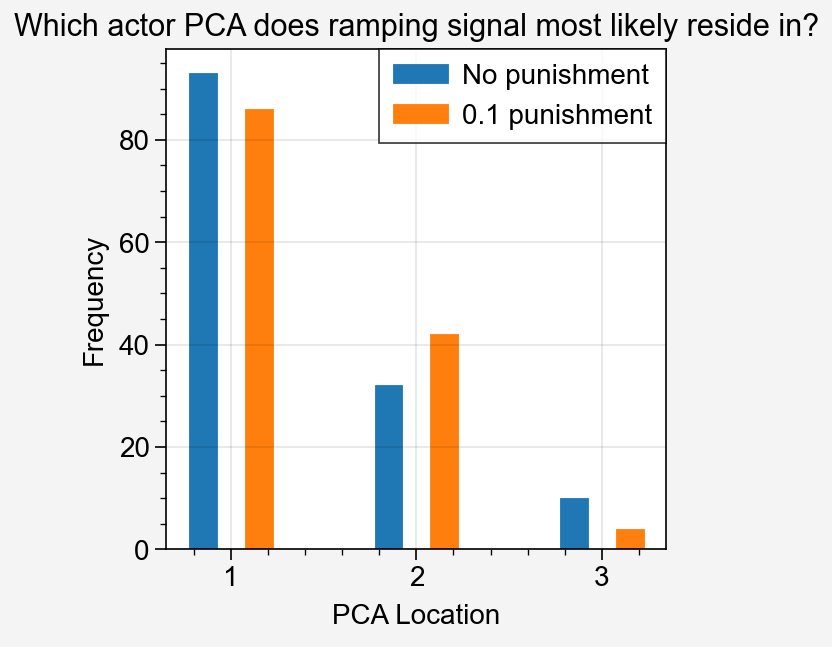

In [434]:
labels = ['No punishment', '0.1 punishment']
fig, ax = pplt.subplots()
for i in range(2): # punishment conditions
    for j in range(3):
        if j == 0:
            ax.bar(i*0.3-0.15+j, (ramp_location[i] == j).sum(), width=0.3, c=rgb_colors[i],
                   label=labels[i])
        else:
            ax.bar(i*0.3-0.15+j, (ramp_location[i] == j).sum(), width=0.3, c=rgb_colors[i])
ax.format(xlocator=range(3), xformatter=['1', '2', '3'], xlabel='PCA Location',
          ylabel='Frequency', title='Which actor PCA does ramping signal most likely reside in?')
ax.legend(ncols=1)

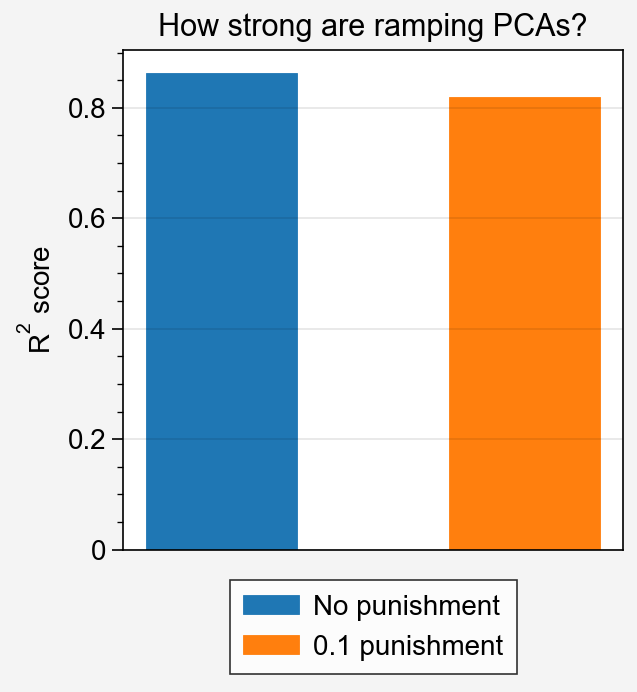

In [439]:
labels = ['No punishment', '0.1 punishment']
fig, ax = pplt.subplots() 
for i in range(2): # punishment conditions
    ax.bar(i*0.3-0.15+j, (ramp_r2[i]).mean(), width=0.3, c=rgb_colors[i],
            label=labels[i])
ax.format(xlocator=[], xformatter=['1', '2', '3'], xlabel='',
          ylabel='$R^2$ score', title='How strong are ramping PCAs?')
ax.legend(ncols=1, loc='b')

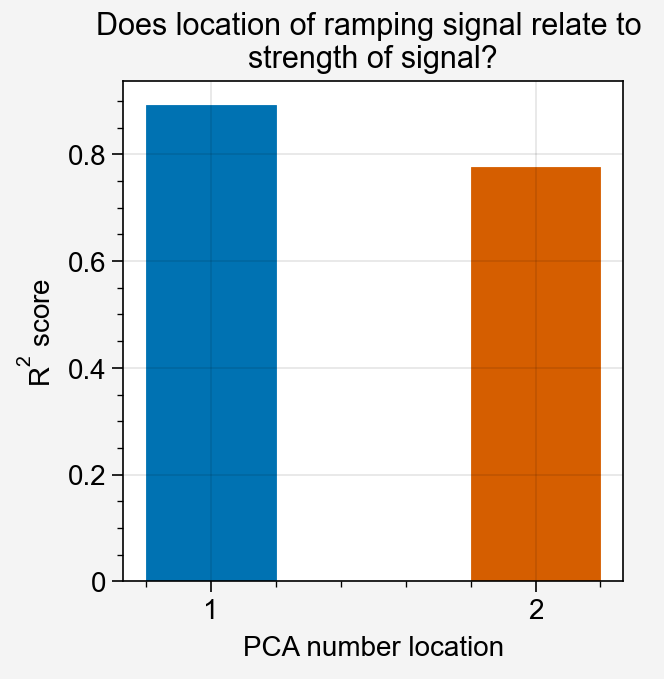

In [511]:
fig, ax = pplt.subplots()
for i in range(2): # pca locaions
    model_idxs = (ramp_location == i)
    ax.bar(i, ramp_r2[model_idxs].mean())
 
ax.format(xlocator=range(2), xformatter=['1', '2'], xlabel='PCA number location',
          title='Does location of ramping signal relate to \nstrength of signal?',
          ylabel='$R^2$ score')

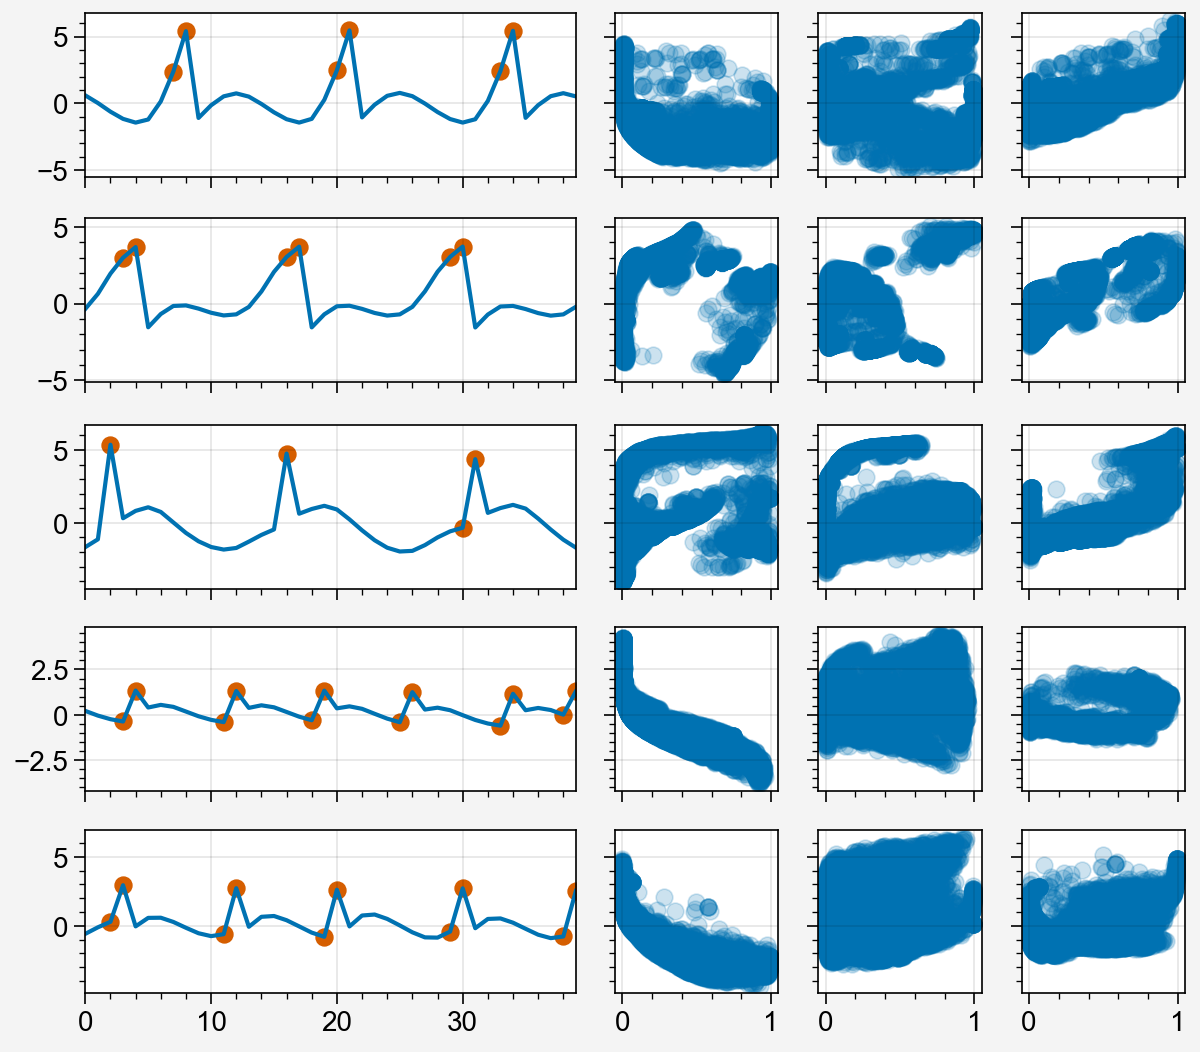

In [472]:
pca2s = np.argwhere(ramp_location == 2)
model_idxs = [4, 8, 9, 10, 12]
fig, ax = pplt.subplots(nrows=5, ncols=4, wratios=(3, 1, 1, 1), refaspect=3, figwidth=6)
for i in range(5):
    idx = pca2s[model_idxs[i]]
    postfix = postfixes[idx[0]]
    model = models[idx[1]]
    t = trials[idx[2]]
    chk = chks[idx[3]]
    
    exp_name = f"p{model}n50{postfix}"
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
    res = evalu(model, obs_rms)
    res = reshape_parallel_evalu_res(res, meta_balloons=40)

    pca_as = comb_pca(res, 'actor0')
    ap = np.vstack(res['action_probs'])[:, 1]
    pca = np.vstack(pca_as)

    ep = 10
    a_idxs = np.argwhere(res['actions'][ep][200:240].reshape(-1)).reshape(-1)
    ax[i, 0].plot(pca_as[ep][200:240, 2])
    ax[i, 0].scatter(a_idxs, pca_as[ep][200+a_idxs, 2])
    for j in range(3):
        ax[i, j+1].scatter(ap, pca[:, j], alpha=0.2) 

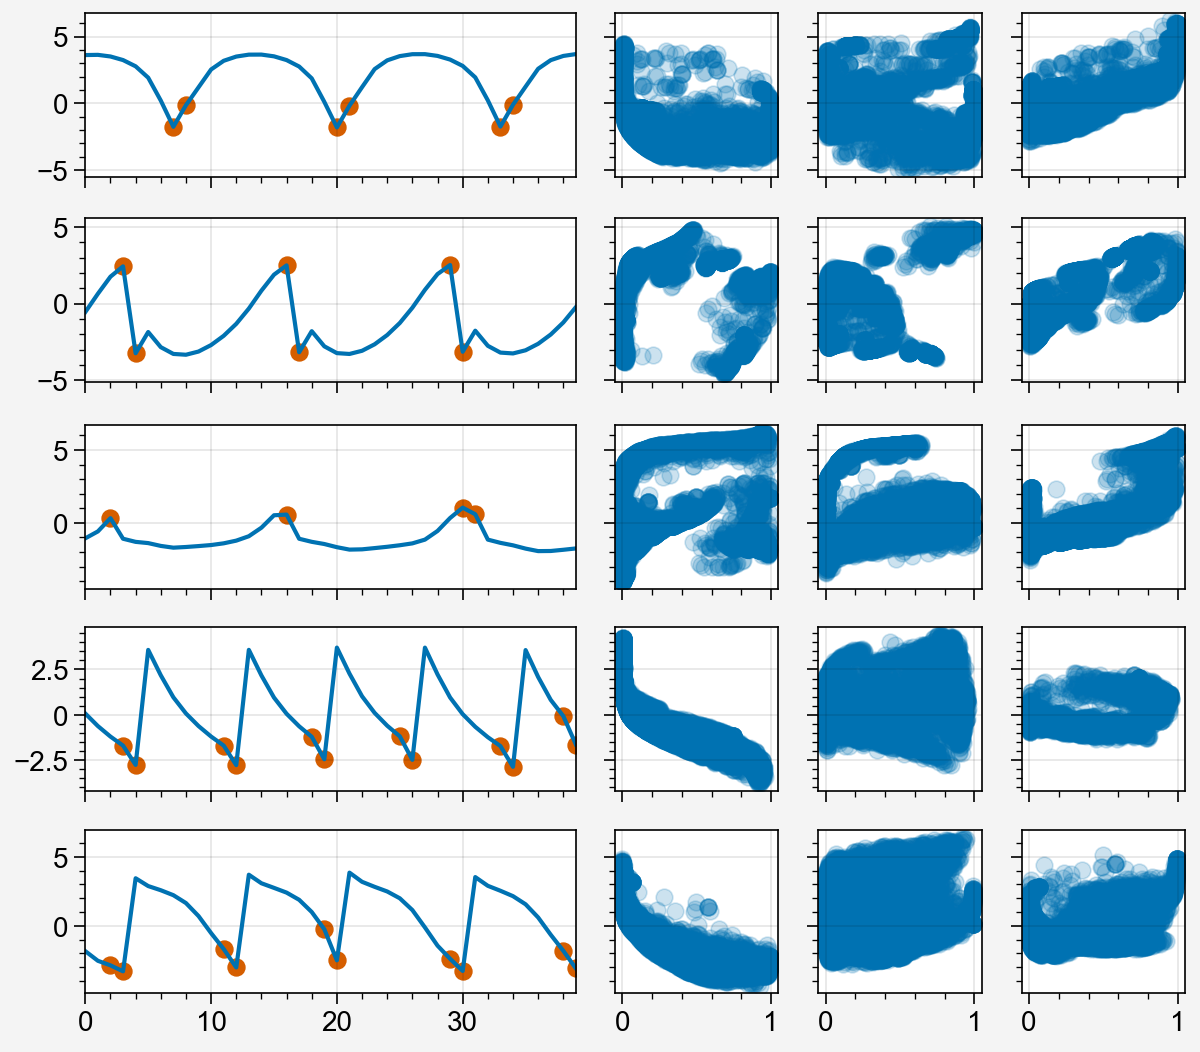

In [473]:
pca2s = np.argwhere(ramp_location == 2)
model_idxs = [4, 8, 9, 10, 12]
fig, ax = pplt.subplots(nrows=5, ncols=4, wratios=(3, 1, 1, 1), refaspect=3, figwidth=6)
for i in range(5):
    idx = pca2s[model_idxs[i]]
    postfix = postfixes[idx[0]]
    model = models[idx[1]]
    t = trials[idx[2]]
    chk = chks[idx[3]]
    
    exp_name = f"p{model}n50{postfix}"
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
    res = evalu(model, obs_rms)
    res = reshape_parallel_evalu_res(res, meta_balloons=40)

    pca_as = comb_pca(res, 'actor0')
    ap = np.vstack(res['action_probs'])[:, 1]
    pca = np.vstack(pca_as)

    ep = 10
    a_idxs = np.argwhere(res['actions'][ep][200:240].reshape(-1)).reshape(-1)
    ax[i, 0].plot(pca_as[ep][200:240, 0])
    ax[i, 0].scatter(a_idxs, pca_as[ep][200+a_idxs, 0])
    for j in range(3):
        ax[i, j+1].scatter(ap, pca[:, j], alpha=0.2) 

p1.0n50 1 210 0.9960572605814645


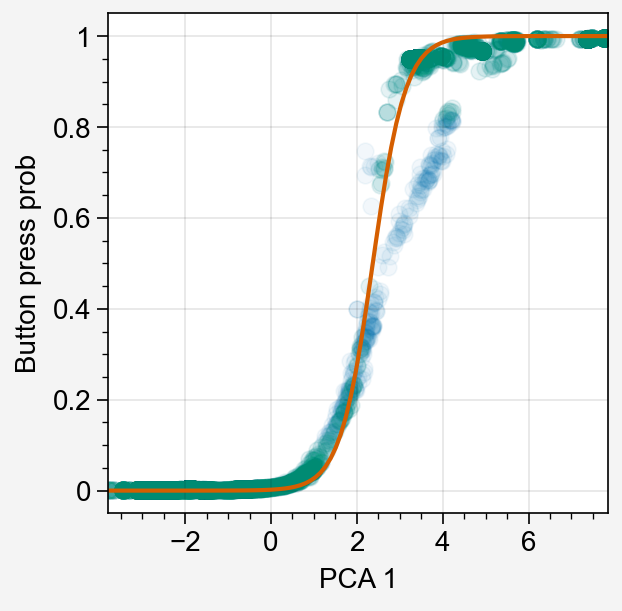

In [575]:
idxs = np.stack(np.unravel_index((-ramp_r2).reshape(-1).argsort(), ramp_r2.shape)).T
idx = idxs[2]
postfix = postfixes[idx[0]]
model = models[idx[1]]
t = trials[idx[2]]
chk = chks[idx[3]]

exp_name = f"p{model}n50{postfix}"
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=40)

pca_as = comb_pca(res, 'actor0')
x, x0, k, ypred, r2_indiv, r2 = fit_ramp(res, pca=0, plot=True)
print(exp_name, t, chk, r2)

In [585]:
find_best_pca_ramp(res, layer='shared1')

(1, 0.8775545983324868)

0.5167013507146565


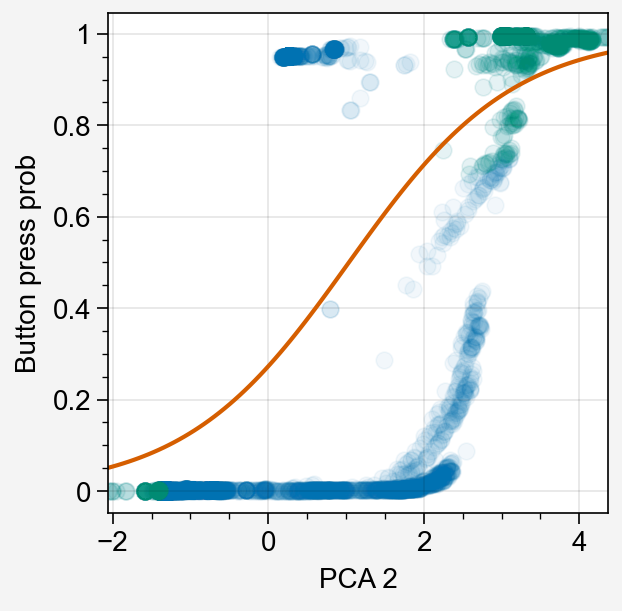

In [586]:

x, x0, k, ypred, r2_indiv, r2 = fit_ramp(res, layer='shared1', pca=1, plot=True)
print(r2)

In [772]:

pca_as = comb_pca(res, 'critic0')
pcas = np.vstack(pca_as)
ap = np.vstack(res['action_probs'])[:, 1]
actions  = np.vstack(res['actions'])
i = 0
lm = LogisticRegression()
lm.fit(pcas[:, i].reshape(-1, 1), actions)
ypred = lm.predict(pcas[:, i].reshape(-1, 1))
f1_score(actions.reshape(-1), ypred)

0.9634276970160673

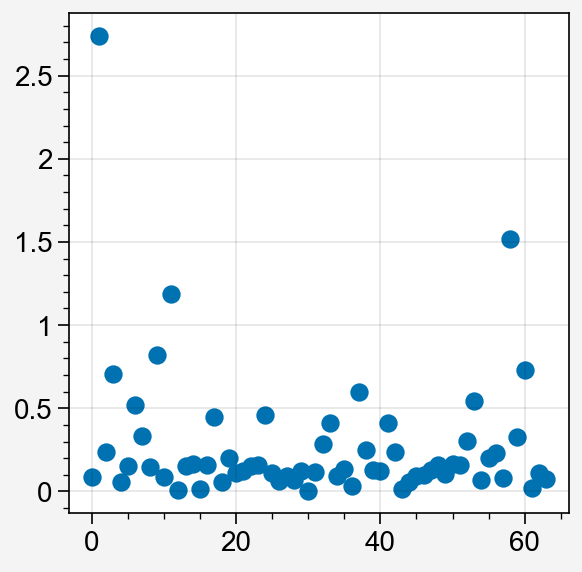

In [701]:
fig, ax = pplt.subplots()
ax.scatter(np.abs(activ).mean(axis=0)*np.abs(lm.coef_).reshape(-1))

IndexError: index 9 is out of bounds for axis 0 with size 9

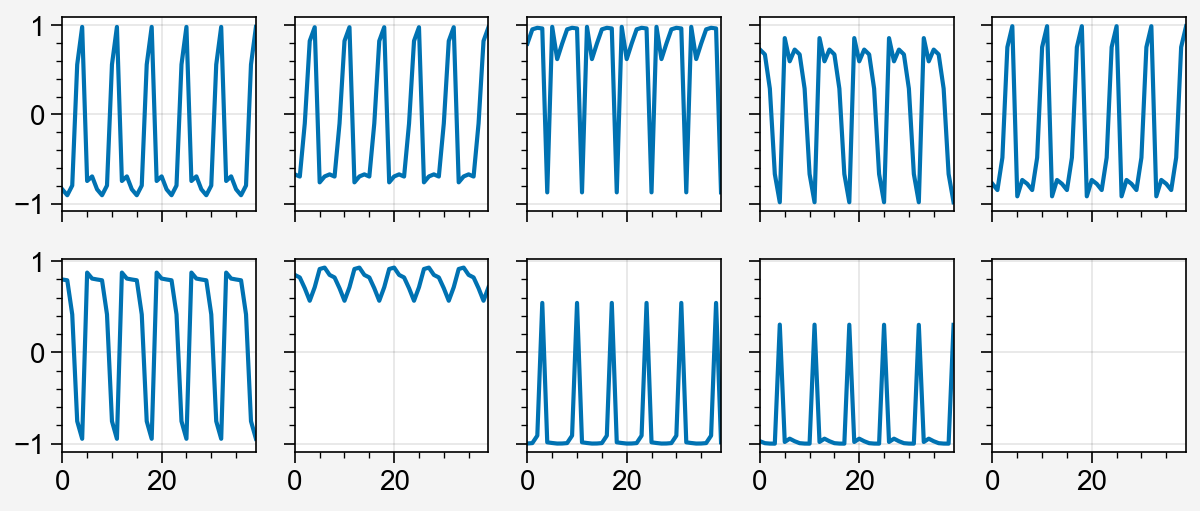

In [692]:
ep = 10
ramp_strengths = np.abs(activ).mean(axis=0)*np.abs(lm.coef_).reshape(-1)
idxs = np.argwhere(ramp_strengths > 0.4).reshape(-1)
fig, ax = pplt.subplots(nrows=2, ncols=5, figwidth=6)
for i in range(10):
    ax[i].plot(res['activations']['actor0'][10][200:240, idxs[i]])


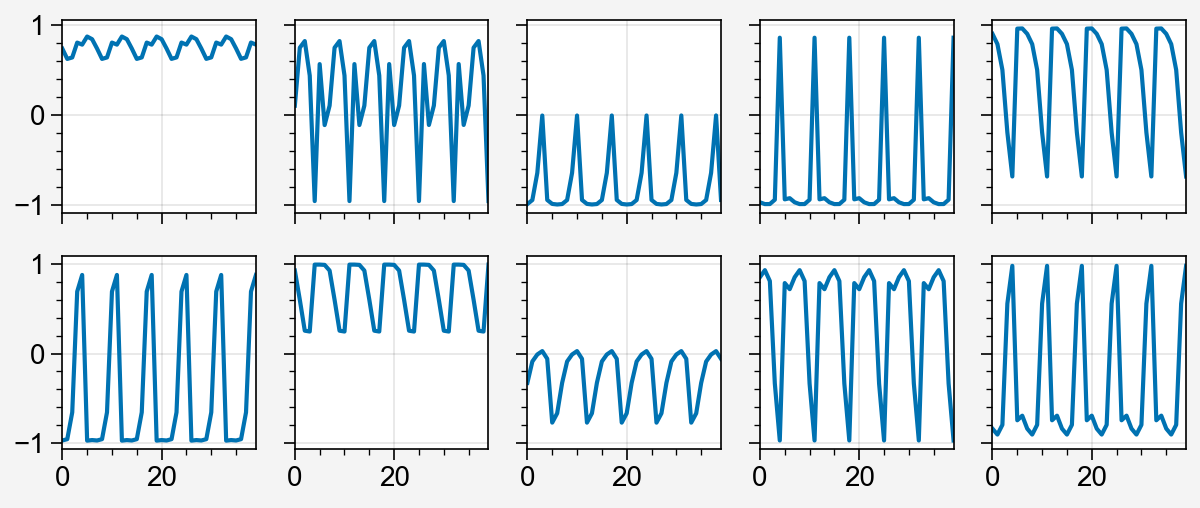

In [694]:
ep = 10
ramp_strengths = np.abs(activ).mean(axis=0)*np.abs(lm.coef_).reshape(-1)
idxs = np.argwhere(ramp_strengths > 0.4).reshape(-1)
fig, ax = pplt.subplots(nrows=2, ncols=5, figwidth=6)
for i in range(10):
    ax[i].plot(res['activations']['actor0'][10][200:240, i])


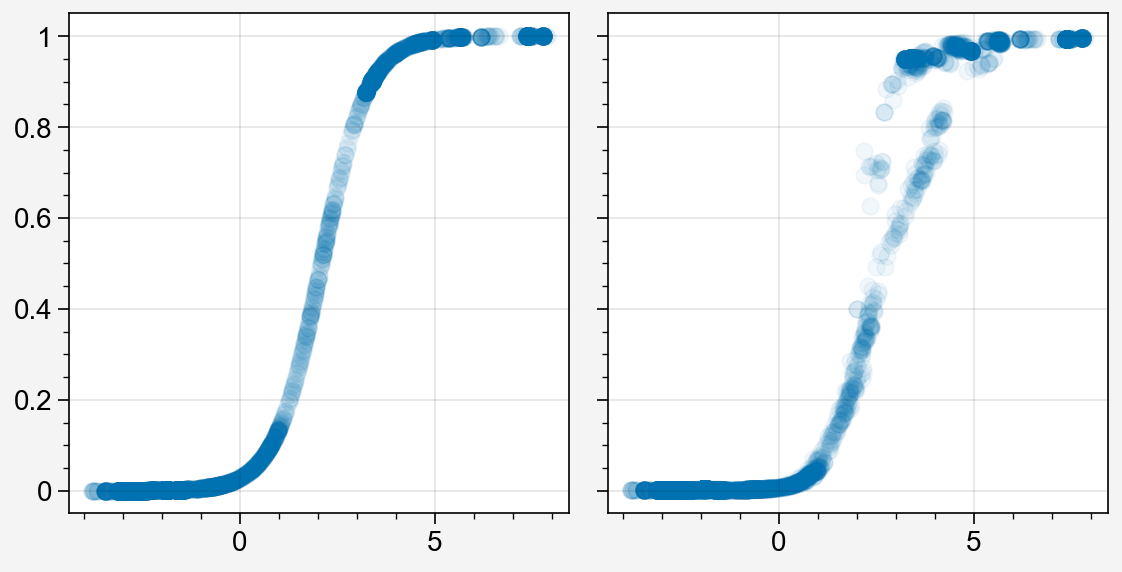

In [626]:
fig, ax = pplt.subplots(ncols=3)
probs = lm.predict_proba(pcas[:, 0].reshape(-1, 1))[:, 1]
ax[0].scatter(pcas[:, 0], probs, alpha=0.05)
probs = np.vstack(res['action_probs'])[:, 1]
ax[1].scatter(pcas[:, 0], probs, alpha=0.05)
ax[2].scatter()

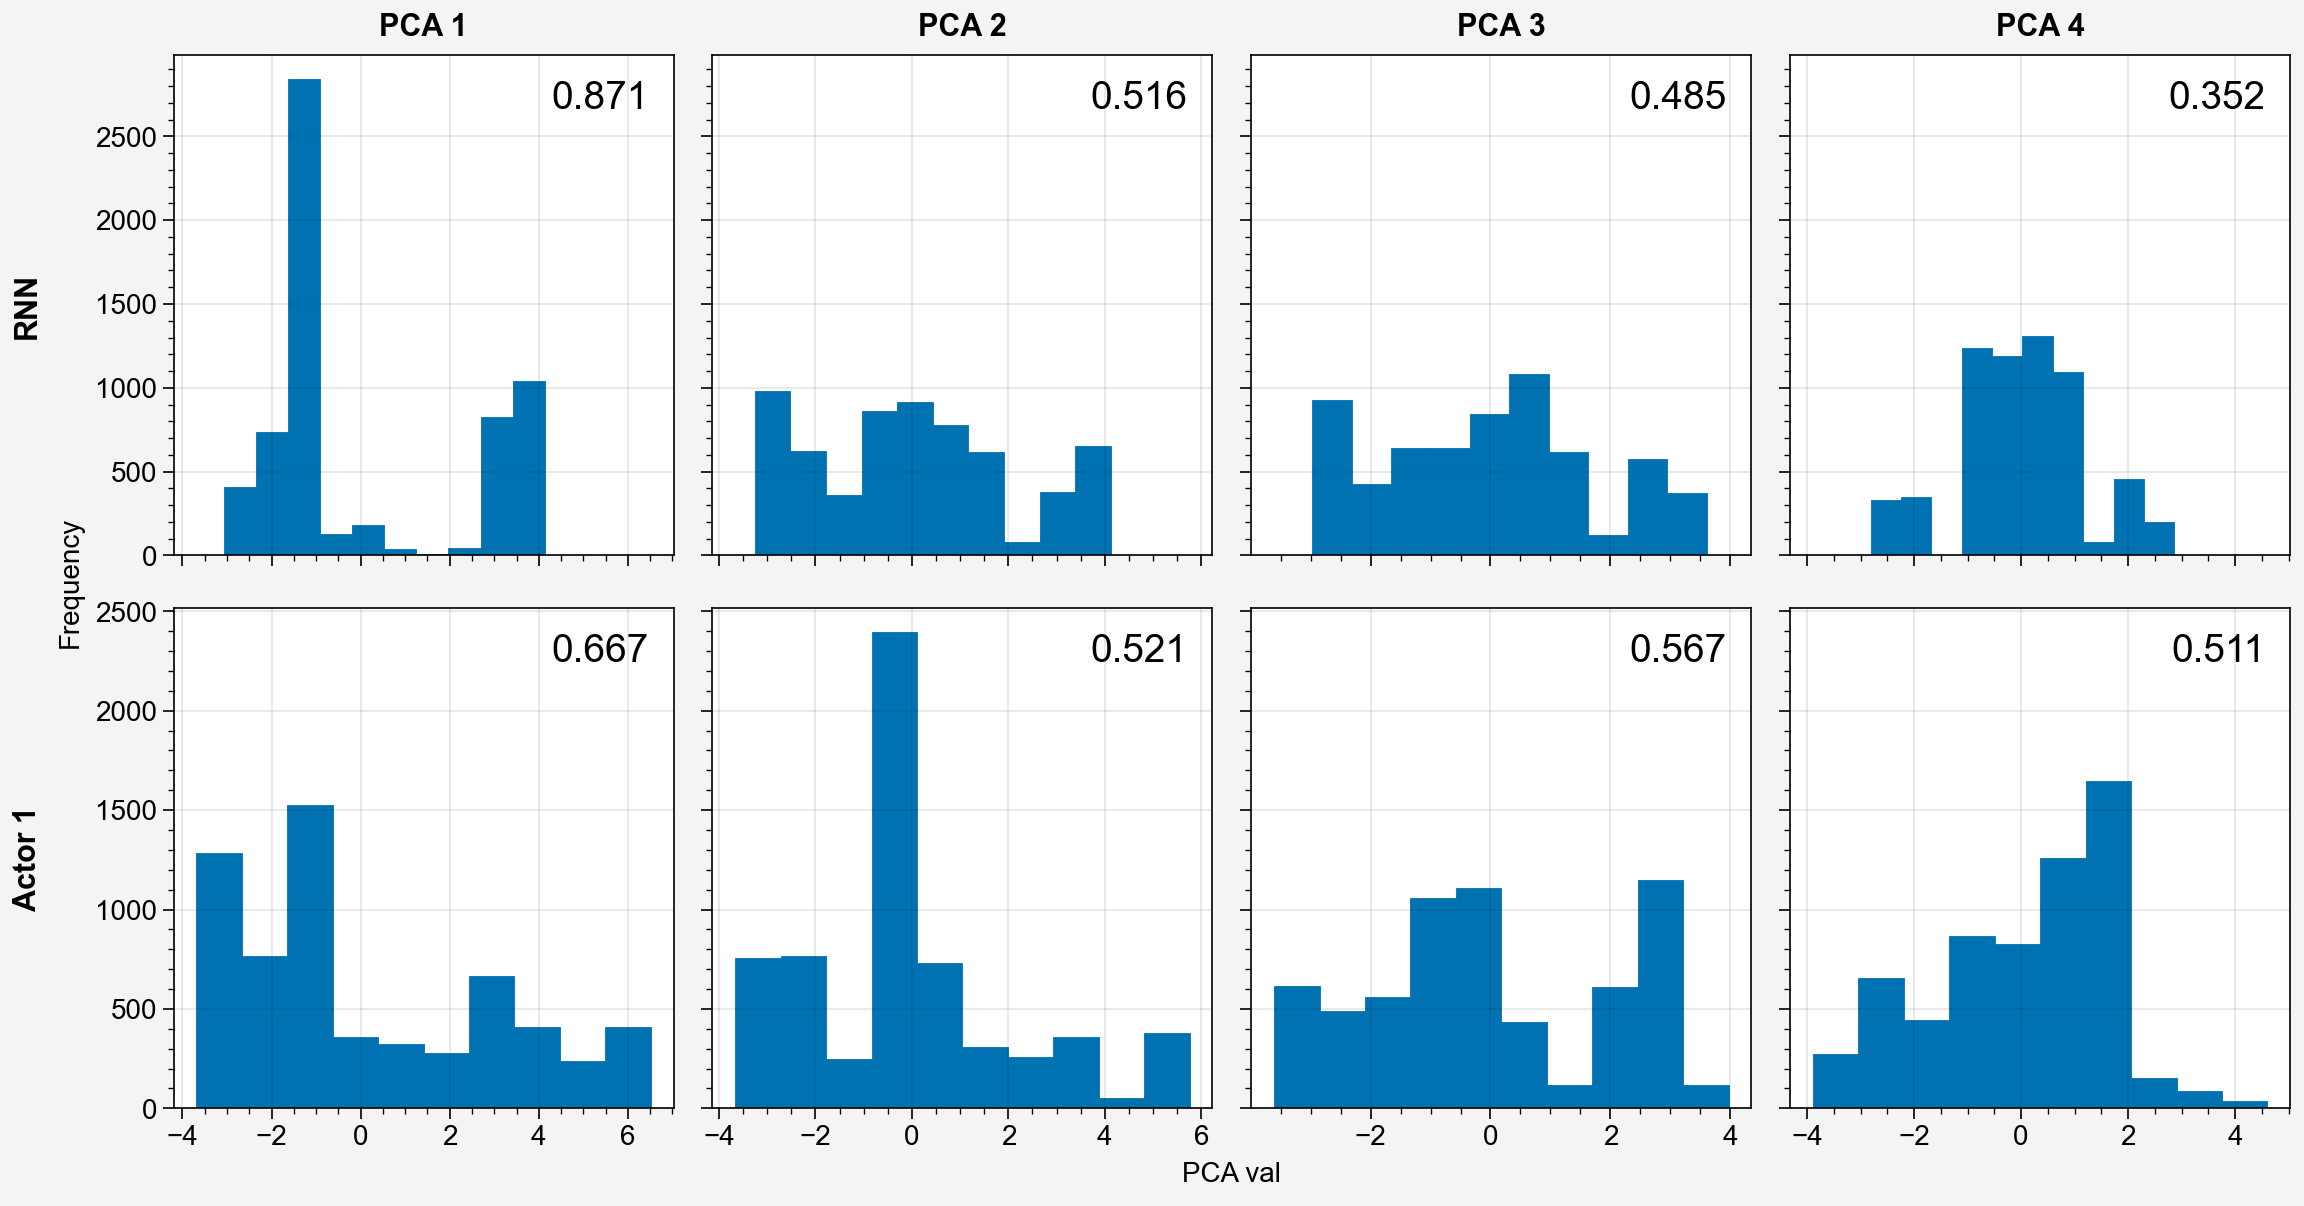

In [356]:
from scipy.stats import skew, kurtosis
fig, ax = pplt.subplots(ncols=4, nrows=2)

layers = ['shared1', 'actor0']
for i, layer in enumerate(layers):
    pca_as = comb_pca(res, layer)
    for j in range(4):
        pca_a = np.vstack(pca_as)[:, j]
        s = skew(pca_a)
        k = kurtosis(pca_a)
        n = len(pca_a)
        bi_coef = ((s ** 2) + 1) / (k + 3 * ((n - 1) ** 2) / ((n - 2) * (n - 3)))
        ax[i, j].hist(pca_a)
        ax[i, j].text(0.95, 0.95, f'{bi_coef:.3f}', va='top', ha='right', transform=ax[i, j].transAxes,
                      fontsize=14)
ax.format(leftlabels=['RNN', 'Actor 1'], xlabel='PCA val', toplabels=['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4'],
          ylabel='Frequency')

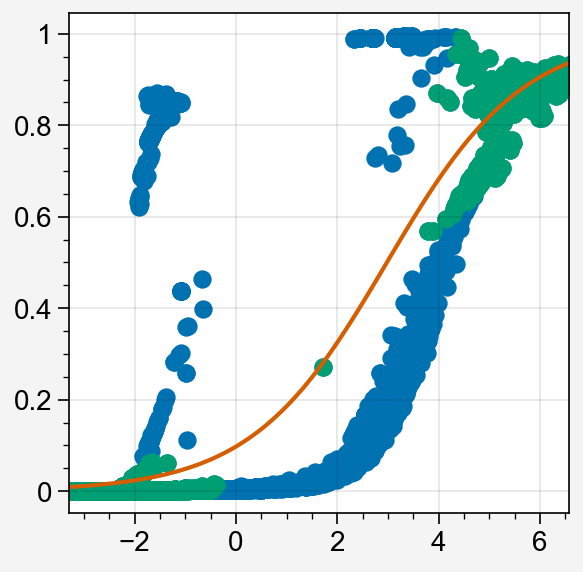

In [212]:

x, x0, k, ypred, r2_indiv, r2 = fit_ramp(res, pca=0, plot=True)